In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import gc

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)



In [8]:

train_dtypes = {
    'store_nbr': 'int8',
    'item_nbr': 'int32', 
    'unit_sales': 'float32',
    'onpromotion': 'boolean'
}

try:
    train = pd.read_csv('train.csv', dtype=train_dtypes, parse_dates=['date'])
    print(f"Loaded train: {train.shape}")
except MemoryError:
    print("Memory error - loading in chunks...")
    
    def load_train_chunks(chunk_size=100000, max_rows=2000000):
        chunks = []
        rows_read = 0
        
        try:
            for chunk in pd.read_csv('train.csv', dtype=train_dtypes, 
                                   parse_dates=['date'], chunksize=chunk_size):
                chunks.append(chunk)
                rows_read += len(chunk)
                
                if rows_read >= max_rows:
                    break
            
            return pd.concat(chunks, ignore_index=True)
        
        except MemoryError:
            if chunks:
                return pd.concat(chunks[:5], ignore_index=True)
            else:
                return pd.read_csv('train.csv', dtype=train_dtypes, 
                                 parse_dates=['date'], nrows=100000)
    
    train = load_train_chunks()

test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
transactions = pd.read_csv('transactions.csv')




Loaded train: (125497040, 6)


In [3]:
def memory_usage_mb(df):
    return round(df.memory_usage(deep=True).sum() / 1024**2, 2)

def missing_data_summary(df, name):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing': missing.values,
        'Percent': missing_percent.values
    }).sort_values('Percent', ascending=False)
    return missing_df[missing_df['Missing'] > 0]

## 2. Basic Statistics

In [4]:
datasets_info = {
    'Train': train,
    'Test': test,
    'Sample Sub': sample_submission,
    'Stores': stores,
    'Items': items,
    'Oil': oil,
    'Holidays': holidays,
    'Transactions': transactions
}

print("Dataset Overview:")
print("-" * 40)

for name, df in datasets_info.items():
    if df is not None:
        rows, cols = df.shape
        memory = memory_usage_mb(df)
        print(f"{name:12}: {rows:>8,} × {cols:>2} | {memory:>6} MB")

Dataset Overview:
----------------------------------------
Train       : 125,497,040 ×  6 | 3231.45 MB
Test        : 3,370,464 ×  5 |  270.0 MB
Sample Sub  : 3,370,464 ×  2 |  51.43 MB
Stores      :       54 ×  5 |   0.01 MB
Items       :    4,100 ×  4 |   0.32 MB
Oil         :    1,218 ×  2 |   0.08 MB
Holidays    :      350 ×  6 |    0.1 MB
Transactions:   83,488 ×  3 |   5.97 MB
Test        : 3,370,464 ×  5 |  270.0 MB
Sample Sub  : 3,370,464 ×  2 |  51.43 MB
Stores      :       54 ×  5 |   0.01 MB
Items       :    4,100 ×  4 |   0.32 MB
Oil         :    1,218 ×  2 |   0.08 MB
Holidays    :      350 ×  6 |    0.1 MB
Transactions:   83,488 ×  3 |   5.97 MB


ANALIZA METADANYCH SKLEPÓW:
Kolumny stores.csv: ['store_nbr', 'city', 'state', 'type', 'cluster']
Liczba sklepów: 54

TYPY SKLEPÓW:
   D: 18 (33.3%)
   C: 15 (27.8%)
   A: 9 (16.7%)
   B: 8 (14.8%)
   E: 4 (7.4%)

STANY (TOP 10):
   Pichincha: 19 (35.2%)
   Guayas: 11 (20.4%)
   Azuay: 3 (5.6%)
   Santo Domingo de los Tsachilas: 3 (5.6%)
   Manabi: 3 (5.6%)
   Los Rios: 2 (3.7%)
   Cotopaxi: 2 (3.7%)
   Tungurahua: 2 (3.7%)
   El Oro: 2 (3.7%)
   Bolivar: 1 (1.9%)

MIASTA (TOP 10):
   Quito: 18 (33.3%)
   Guayaquil: 8 (14.8%)
   Cuenca: 3 (5.6%)
   Santo Domingo: 3 (5.6%)
   Latacunga: 2 (3.7%)
   Machala: 2 (3.7%)
   Manta: 2 (3.7%)
   Ambato: 2 (3.7%)
   Cayambe: 1 (1.9%)
   Riobamba: 1 (1.9%)

KLASTRY:
   Liczba klastrów: 17
   Zakres: 1 - 17


ANALIZA METADANYCH SKLEPÓW:
Kolumny stores.csv: ['store_nbr', 'city', 'state', 'type', 'cluster']
Liczba sklepów: 54

TYPY SKLEPÓW:
   D: 18 (33.3%)
   C: 15 (27.8%)
   A: 9 (16.7%)
   B: 8 (14.8%)
   E: 4 (7.4%)

STANY (TOP 10):
   Pichincha: 19 (35.2%)
   Guayas: 11 (20.4%)
   Azuay: 3 (5.6%)
   Santo Domingo de los Tsachilas: 3 (5.6%)
   Manabi: 3 (5.6%)
   Los Rios: 2 (3.7%)
   Cotopaxi: 2 (3.7%)
   Tungurahua: 2 (3.7%)
   El Oro: 2 (3.7%)
   Bolivar: 1 (1.9%)

MIASTA (TOP 10):
   Quito: 18 (33.3%)
   Guayaquil: 8 (14.8%)
   Cuenca: 3 (5.6%)
   Santo Domingo: 3 (5.6%)
   Latacunga: 2 (3.7%)
   Machala: 2 (3.7%)
   Manta: 2 (3.7%)
   Ambato: 2 (3.7%)
   Cayambe: 1 (1.9%)
   Riobamba: 1 (1.9%)

KLASTRY:
   Liczba klastrów: 17
   Zakres: 1 - 17


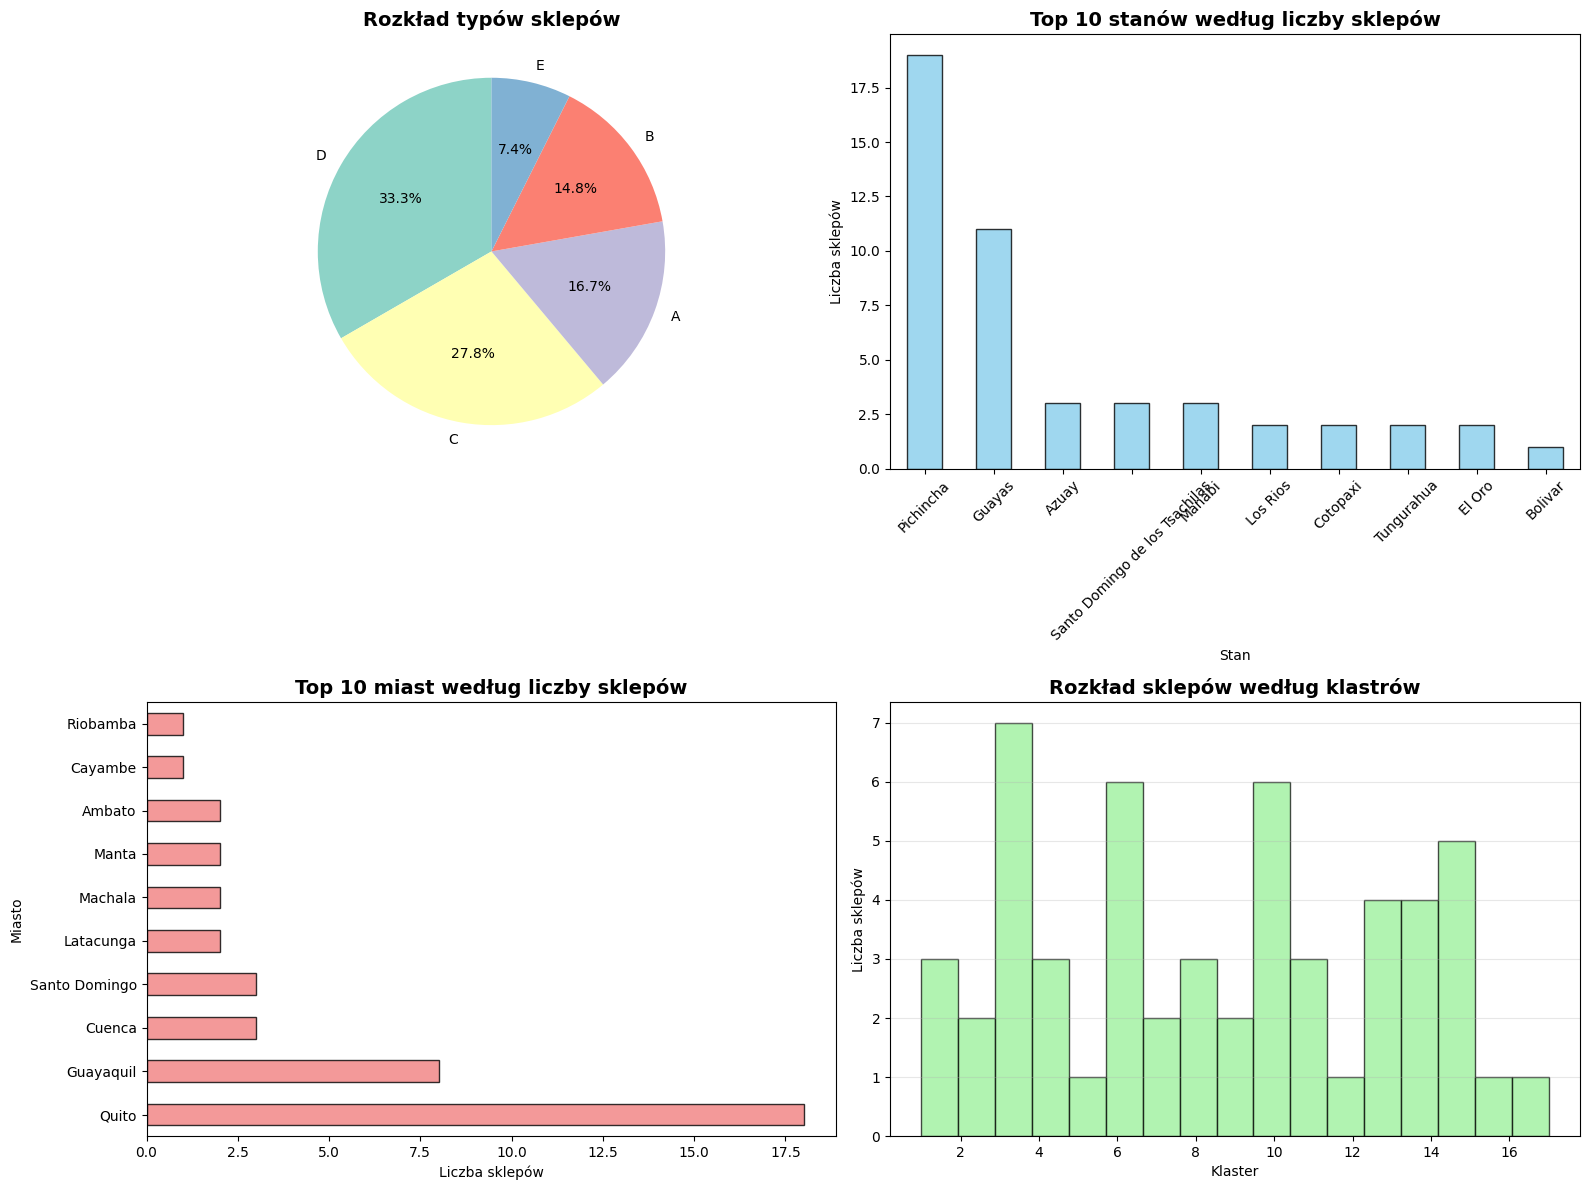

In [5]:
# Analiza metadanych sklepów
print("ANALIZA METADANYCH SKLEPÓW:")
print("=" * 40)

print(f"Kolumny stores.csv: {list(stores.columns)}")
print(f"Liczba sklepów: {len(stores)}")

# Rozkłady kategorii sklepów
print("\nTYPY SKLEPÓW:")
store_type_counts = stores['type'].value_counts()
for store_type, count in store_type_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {store_type}: {count} ({percentage:.1f}%)")

print("\nSTANY (TOP 10):")
state_counts = stores['state'].value_counts().head(10)
for state, count in state_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {state}: {count} ({percentage:.1f}%)")

print("\nMIASTA (TOP 10):")
city_counts = stores['city'].value_counts().head(10)
for city, count in city_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {city}: {count} ({percentage:.1f}%)")

print("\nKLASTRY:")
cluster_counts = stores['cluster'].value_counts().sort_index()
print(f"   Liczba klastrów: {stores['cluster'].nunique()}")
print(f"   Zakres: {stores['cluster'].min()} - {stores['cluster'].max()}")


# Wizualizacja rozkładów
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Typy sklepów - wykres kołowy
colors_pie = plt.cm.Set3(range(len(store_type_counts)))
wedges, texts, autotexts = ax1.pie(store_type_counts.values, labels=store_type_counts.index, 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax1.set_title('Rozkład typów sklepów', fontsize=14, fontweight='bold')

# 2. Top 10 stanów - wykres słupkowy
state_counts.plot(kind='bar', ax=ax2, color='skyblue', alpha=0.8, edgecolor='black')
ax2.set_title('Top 10 stanów według liczby sklepów', fontsize=14, fontweight='bold')
ax2.set_xlabel('Stan')
ax2.set_ylabel('Liczba sklepów')
ax2.tick_params(axis='x', rotation=45)

# 3. Top 10 miast - wykres słupkowy poziomy
city_counts.plot(kind='barh', ax=ax3, color='lightcoral', alpha=0.8, edgecolor='black')
ax3.set_title('Top 10 miast według liczby sklepów', fontsize=14, fontweight='bold')
ax3.set_xlabel('Liczba sklepów')
ax3.set_ylabel('Miasto')

# 4. Rozkład klastrów - histogram
ax4.hist(stores['cluster'], bins=stores['cluster'].nunique(), alpha=0.7, 
         color='lightgreen', edgecolor='black')
ax4.set_title('Rozkład sklepów według klastrów', fontsize=14, fontweight='bold')
ax4.set_xlabel('Klaster')
ax4.set_ylabel('Liczba sklepów')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Analiza typów danych i braków dla każdego zbioru
for name, df in datasets_info.items():
    if df is not None:
        print(f"\nANALIZA: {name.upper()}")
        print("=" * 30)
        
        print(f"Kształt: {df.shape}")
        print(f"Kolumny: {list(df.columns)}")
        
        # Typy danych (uproszczone)
        dtype_counts = df.dtypes.value_counts()
        print(f"Typy: {dict(dtype_counts)}")
        
        # Braki danych - używamy bezpośrednio pandas
        missing_info = df.isnull().sum()
        total_missing = missing_info.sum()
        
        if total_missing > 0:
            print(f"\nBRAKI DANYCH:")
            missing_cols = missing_info[missing_info > 0]
            for col, count in missing_cols.items():
                percent = (count / len(df)) * 100
                print(f"   {col}: {count:,} ({percent:.1f}%)")
        else:
            print("\nBRAKI DANYCH: Brak")
        




ANALIZA: TRAIN
Kształt: (125497040, 6)
Kolumny: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
Typy: {dtype('int64'): np.int64(1), dtype('<M8[ns]'): np.int64(1), dtype('int8'): np.int64(1), dtype('int32'): np.int64(1), dtype('float32'): np.int64(1), BooleanDtype: np.int64(1)}

BRAKI DANYCH:
   onpromotion: 21,657,651 (17.3%)

ANALIZA: TEST
Kształt: (3370464, 5)
Kolumny: ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion']
Typy: {dtype('int64'): np.int64(3), dtype('O'): np.int64(1), dtype('bool'): np.int64(1)}

BRAKI DANYCH: Brak

ANALIZA: SAMPLE SUB
Kształt: (3370464, 2)
Kolumny: ['id', 'unit_sales']
Typy: {dtype('int64'): np.int64(2)}

BRAKI DANYCH: Brak

ANALIZA: STORES
Kształt: (54, 5)
Kolumny: ['store_nbr', 'city', 'state', 'type', 'cluster']
Typy: {dtype('O'): np.int64(3), dtype('int64'): np.int64(2)}

BRAKI DANYCH: Brak

ANALIZA: ITEMS
Kształt: (4100, 4)
Kolumny: ['item_nbr', 'family', 'class', 'perishable']
Typy: {dtype('int64'): np.int64(3), dtype('O'):

ANALIZA ZWROTÓW (ujemne unit_sales):
Liczba zwrotów: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
Średni zwrot: -18.42

TOP 10 SKLEPÓW Z NAJWIĘCEJ ZWROTAMI:
           Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


ANALIZA ZWROTÓW (ujemne unit_sales):
Liczba zwrotów: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
Średni zwrot: -18.42

TOP 10 SKLEPÓW Z NAJWIĘCEJ ZWROTAMI:
           Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


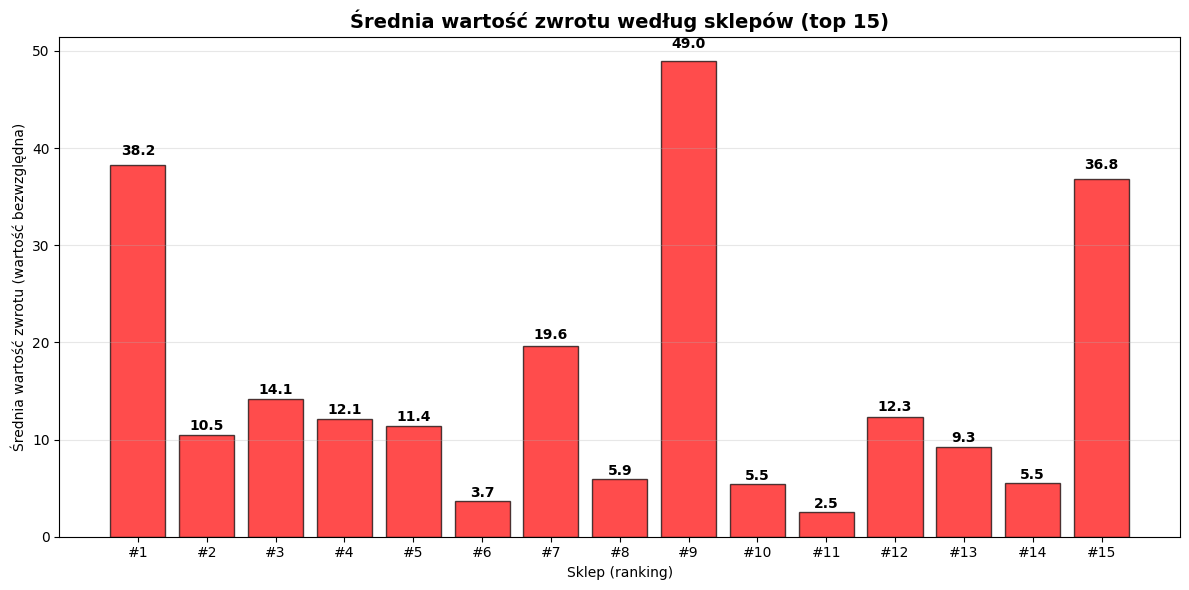

ANALIZA ZWROTÓW (ujemne unit_sales):
Liczba zwrotów: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
Średni zwrot: -18.42

TOP 10 SKLEPÓW Z NAJWIĘCEJ ZWROTAMI:
           Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


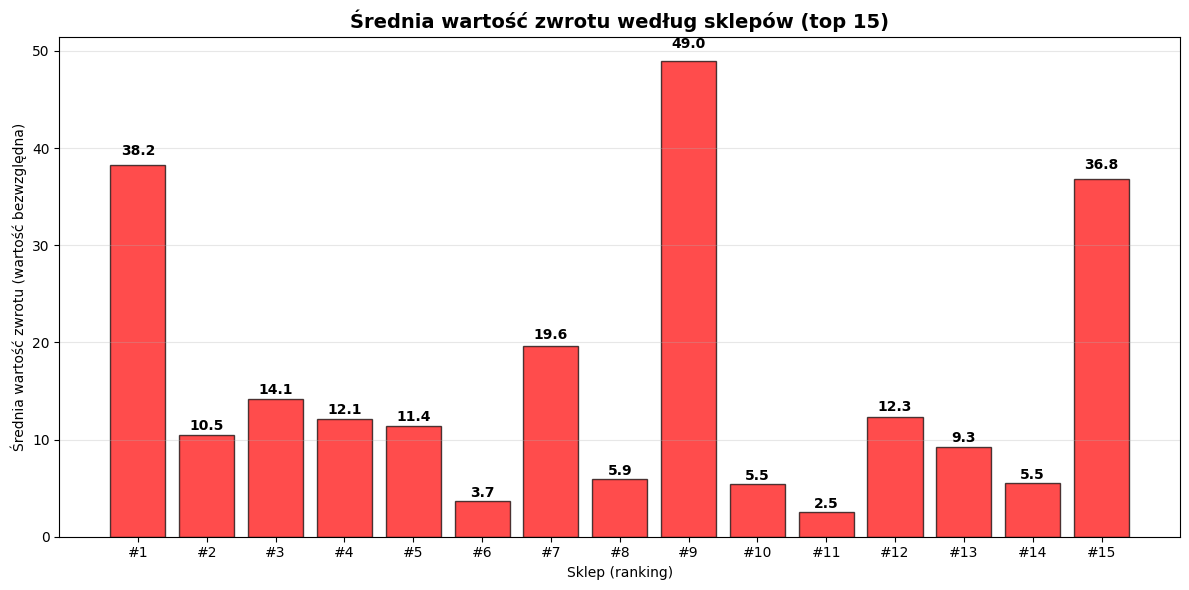


ANALIZA CZYNNIKÓW WPŁYWAJĄCYCH NA ZWROTY

1. ZWROTY WEDŁUG RODZIN PRODUKTÓW:
----------------------------------------
TOP 10 RODZIN z największą liczbą zwrotów:
                     Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot  Procent
family                                                                   
GROCERY I                      2160 -50015.527344     -23.155336     27.7
BEVERAGES                      1361 -42782.000000     -31.434240     17.5
CLEANING                       1026 -11920.000000     -11.617933     13.2
PERSONAL CARE                   401 -14688.000000     -36.628429      5.1
DAIRY                           380  -2962.000000      -7.794737      4.9
PRODUCE                         302  -1845.432007      -6.110702      3.9
HOME AND KITCHEN II             203   -448.000000      -2.206897      2.6
BREAD/BAKERY                    194  -1468.000000      -7.567010      2.5
HOME AND KITCHEN I              179   -896.000000      -5.005587      2.3
HOME CARE               

ANALIZA ZWROTÓW (ujemne unit_sales):
Liczba zwrotów: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
Średni zwrot: -18.42

TOP 10 SKLEPÓW Z NAJWIĘCEJ ZWROTAMI:
           Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


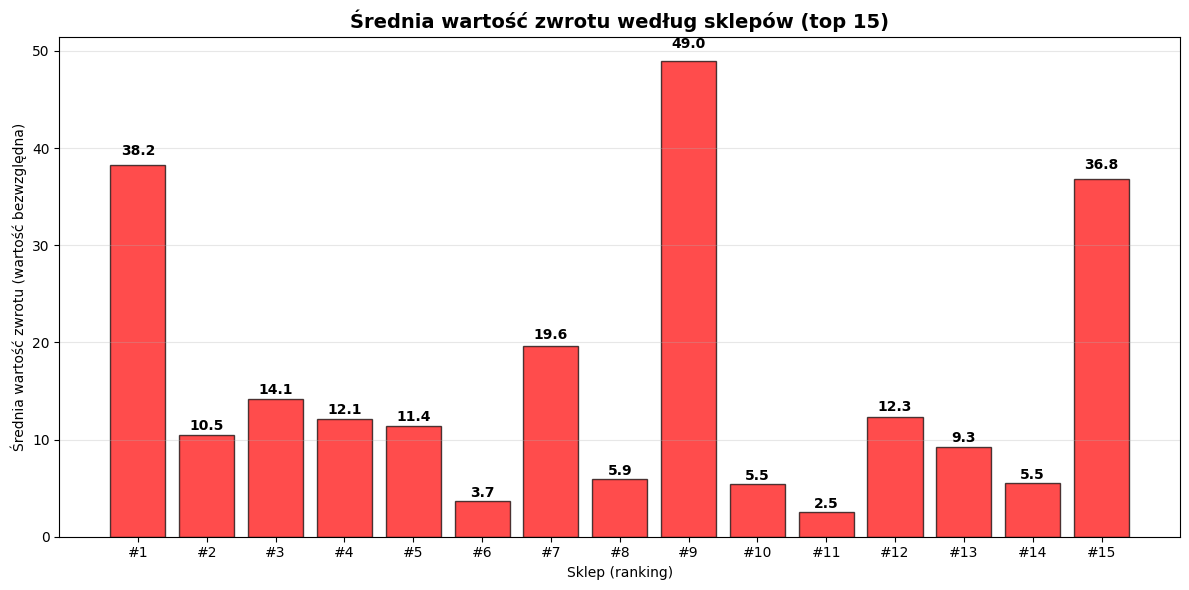


ANALIZA CZYNNIKÓW WPŁYWAJĄCYCH NA ZWROTY

1. ZWROTY WEDŁUG RODZIN PRODUKTÓW:
----------------------------------------
TOP 10 RODZIN z największą liczbą zwrotów:
                     Liczba_zwrotów  Suma_zwrotów  Średnia_zwrot  Procent
family                                                                   
GROCERY I                      2160 -50015.527344     -23.155336     27.7
BEVERAGES                      1361 -42782.000000     -31.434240     17.5
CLEANING                       1026 -11920.000000     -11.617933     13.2
PERSONAL CARE                   401 -14688.000000     -36.628429      5.1
DAIRY                           380  -2962.000000      -7.794737      4.9
PRODUCE                         302  -1845.432007      -6.110702      3.9
HOME AND KITCHEN II             203   -448.000000      -2.206897      2.6
BREAD/BAKERY                    194  -1468.000000      -7.567010      2.5
HOME AND KITCHEN I              179   -896.000000      -5.005587      2.3
HOME CARE               

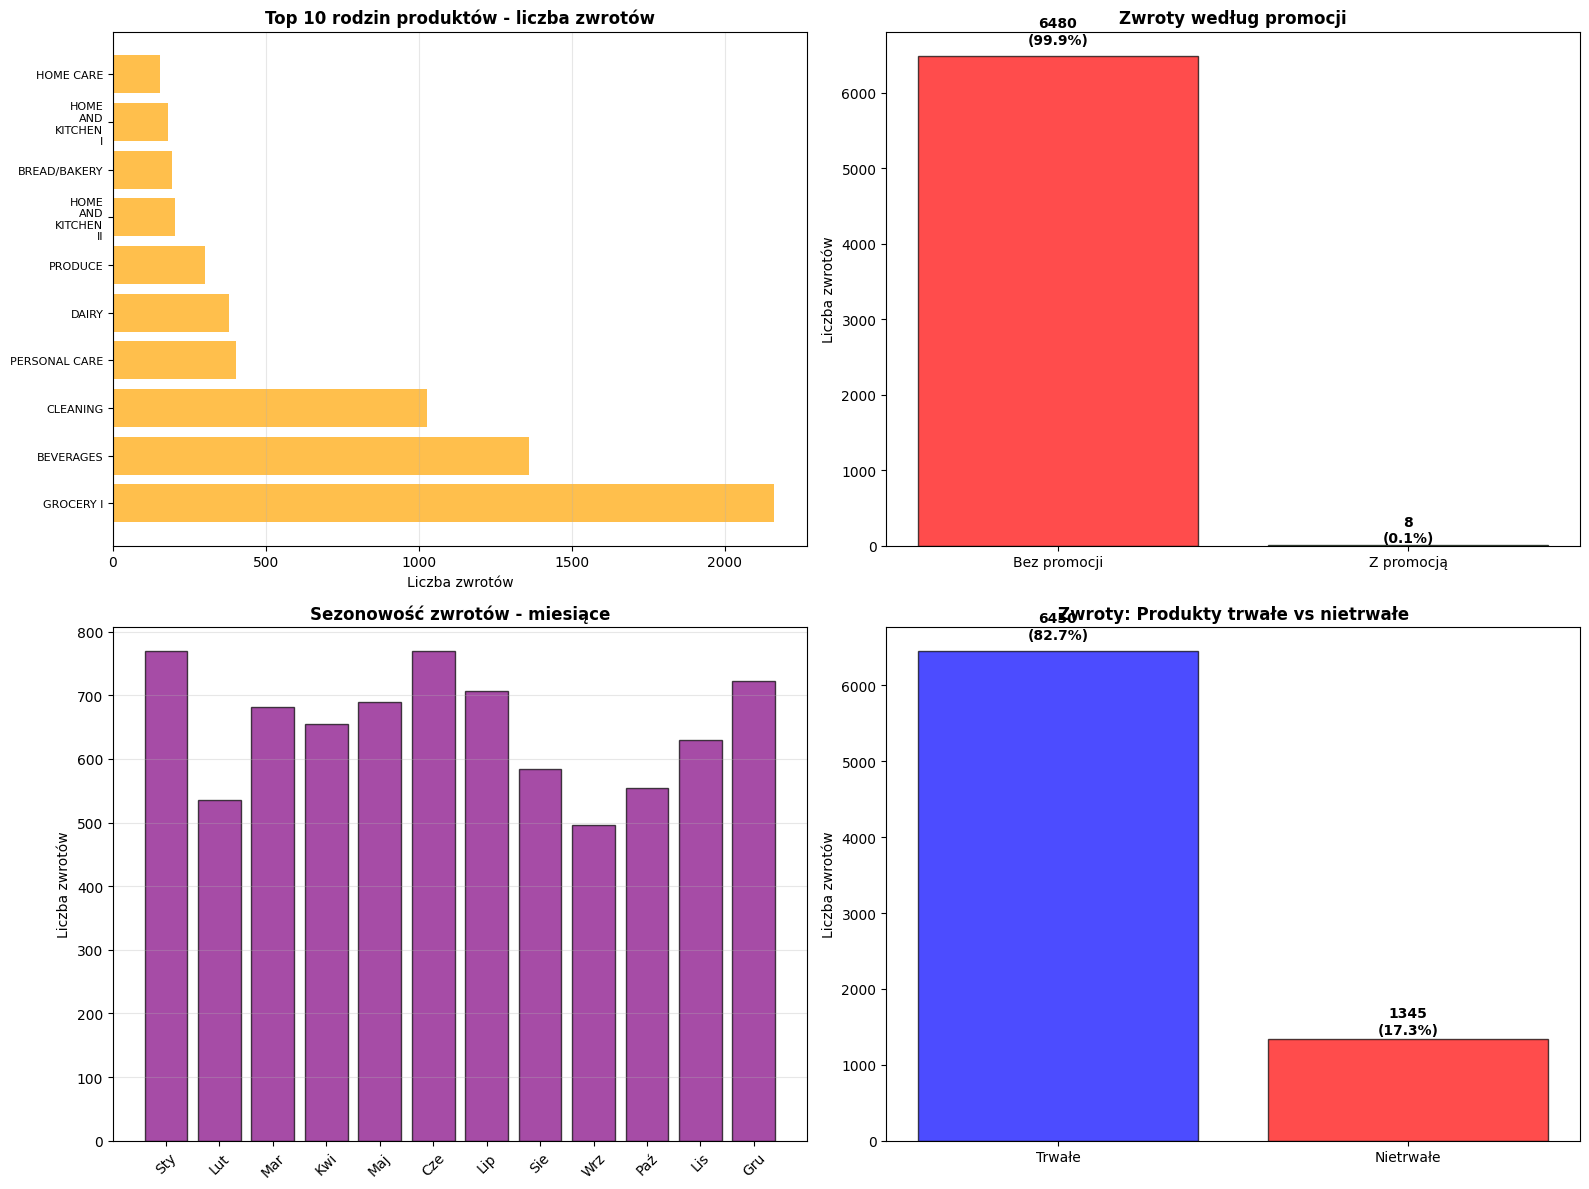

In [7]:
# Analiza zwrotów (ujemne wartości)
returns = train[train['unit_sales'] < 0]

print("ANALIZA ZWROTÓW (ujemne unit_sales):")
print("=" * 40)
print(f"Liczba zwrotów: {len(returns):,}")
print(f"Procent wszystkich transakcji: {len(returns)/len(train)*100:.2f}%")
print(f"Najgorszy zwrot: {returns['unit_sales'].min():.2f}")
print(f"Średni zwrot: {returns['unit_sales'].mean():.2f}")

returns_by_store = returns.groupby('store_nbr')['unit_sales'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False)
returns_by_store.columns = ['Liczba_zwrotów', 'Suma_zwrotów', 'Średnia_zwrot']
returns_by_store['Średnia_zwrot'] = returns_by_store['Średnia_zwrot'].round(2)

print(f"\nTOP 10 SKLEPÓW Z NAJWIĘCEJ ZWROTAMI:")
print(returns_by_store.head(10))

# Wizualizacja zwrotów - tylko średnia wartość zwrotu
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Wykres średniej wartości zwrotu na sklep (wartości są ujemne, więc odwracamy)
top_15_stores = returns_by_store.head(15)
ax.bar(range(len(top_15_stores)), -top_15_stores['Średnia_zwrot'], color='red', alpha=0.7, edgecolor='black')
ax.set_title('Średnia wartość zwrotu według sklepów (top 15)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sklep (ranking)')
ax.set_ylabel('Średnia wartość zwrotu (wartość bezwzględna)')
ax.set_xticks(range(len(top_15_stores)))
ax.set_xticklabels([f'#{i+1}' for i in range(len(top_15_stores))])
ax.grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for i, value in enumerate(-top_15_stores['Średnia_zwrot']):
    ax.text(i, value + value*0.02, f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ANALIZA CZYNNIKÓW WPŁYWAJĄCYCH NA ZWROTY
print("\n" + "="*60)
print("ANALIZA CZYNNIKÓW WPŁYWAJĄCYCH NA ZWROTY")
print("="*60)

# 1. Analiza według rodzin produktów
print("\n1. ZWROTY WEDŁUG RODZIN PRODUKTÓW:")
print("-" * 40)

# Mapowanie produktów na rodziny
item_family_map = items.set_index('item_nbr')['family'].to_dict()
returns['family'] = returns['item_nbr'].map(item_family_map)

returns_by_family = returns.groupby('family')['unit_sales'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False)
returns_by_family.columns = ['Liczba_zwrotów', 'Suma_zwrotów', 'Średnia_zwrot']
returns_by_family['Procent'] = (returns_by_family['Liczba_zwrotów'] / len(returns) * 100).round(1)

print("TOP 10 RODZIN z największą liczbą zwrotów:")
print(returns_by_family.head(10))

# 2. Analiza według promocji
print("\n2. ZWROTY A PROMOCJE:")
print("-" * 25)

promo_returns = returns.dropna(subset=['onpromotion'])
returns_promo_analysis = promo_returns.groupby('onpromotion')['unit_sales'].agg(['count', 'mean']).round(2)
returns_promo_analysis.index = returns_promo_analysis.index.map({False: 'Bez promocji', True: 'Z promocją'})
returns_promo_analysis.columns = ['Liczba_zwrotów', 'Średni_zwrot']

# Dodaj procenty
total_returns_with_promo_data = len(promo_returns)
returns_promo_analysis['Procent'] = (returns_promo_analysis['Liczba_zwrotów'] / total_returns_with_promo_data * 100).round(1)

print(returns_promo_analysis)

# 3. Analiza według typów sklepów
print("\n3. ZWROTY WEDŁUG TYPÓW SKLEPÓW:")
print("-" * 35)

store_type_map = stores.set_index('store_nbr')['type'].to_dict()
returns['store_type'] = returns['store_nbr'].map(store_type_map)

returns_by_type = returns.groupby('store_type')['unit_sales'].agg(['count', 'mean']).round(2)
returns_by_type.columns = ['Liczba_zwrotów', 'Średni_zwrot']
returns_by_type['Procent'] = (returns_by_type['Liczba_zwrotów'] / len(returns) * 100).round(1)
returns_by_type = returns_by_type.sort_values('Liczba_zwrotów', ascending=False)

print(returns_by_type)

# 4. Analiza sezonowa zwrotów
print("\n4. SEZONOWOŚĆ ZWROTÓW:")
print("-" * 25)

returns['month'] = pd.to_datetime(returns['date']).dt.month
monthly_returns = returns.groupby('month')['unit_sales'].count().to_frame('Liczba_zwrotów')

month_names = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru']
print("Zwroty według miesięcy:")
for month, count in monthly_returns.iterrows():
    print(f"{month_names[month-1]}: {count['Liczba_zwrotów']}")

returns['dayofweek'] = pd.to_datetime(returns['date']).dt.dayofweek
weekday_returns = returns.groupby('dayofweek')['unit_sales'].count().to_frame('Liczba_zwrotów')

day_names = ['Pon', 'Wto', 'Śro', 'Czw', 'Pią', 'Sob', 'Nie']
print("\nZwroty według dni tygodnia:")
for day, count in weekday_returns.iterrows():
    print(f"{day_names[day]}: {count['Liczba_zwrotów']}")

# 5. Analiza zwrotów według nietrwałości produktów
print("\n5. ZWROTY: PRODUKTY NIETRWAŁE VS TRWAŁE:")
print("-" * 45)

item_perishable_map = items.set_index('item_nbr')['perishable'].to_dict()
returns['perishable'] = returns['item_nbr'].map(item_perishable_map)

returns_perishable = returns.groupby('perishable')['unit_sales'].count().to_frame('Liczba_zwrotów')
returns_perishable.index = returns_perishable.index.map({0: 'Trwałe', 1: 'Nietrwałe'})

total_returns_perishable = len(returns.dropna(subset=['perishable']))
returns_perishable['Procent'] = (returns_perishable['Liczba_zwrotów'] / total_returns_perishable * 100).round(1)

print(returns_perishable)

# WIZUALIZACJA CZYNNIKÓW WPŁYWAJĄCYCH NA ZWROTY
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 rodzin produktów z najwięcej zwrotami
top_families = returns_by_family.head(10)
ax1.barh(range(len(top_families)), top_families['Liczba_zwrotów'], color='orange', alpha=0.7)
ax1.set_title('Top 10 rodzin produktów - liczba zwrotów', fontweight='bold')
ax1.set_xlabel('Liczba zwrotów')
ax1.set_yticks(range(len(top_families)))
ax1.set_yticklabels([f.replace(' ', '\n') if len(f) > 15 else f for f in top_families.index], fontsize=8)
ax1.grid(axis='x', alpha=0.3)

# 2. Zwroty według promocji
promo_labels = returns_promo_analysis.index
promo_values = returns_promo_analysis['Liczba_zwrotów']
colors = ['red', 'green']
bars2 = ax2.bar(promo_labels, promo_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Zwroty według promocji', fontweight='bold')
ax2.set_ylabel('Liczba zwrotów')
for bar, value, pct in zip(bars2, promo_values, returns_promo_analysis['Procent']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

# 3. Sezonowość - miesiące
month_labels = [month_names[i-1] for i in monthly_returns.index]
ax3.bar(month_labels, monthly_returns['Liczba_zwrotów'], color='purple', alpha=0.7, edgecolor='black')
ax3.set_title('Sezonowość zwrotów - miesiące', fontweight='bold')
ax3.set_ylabel('Liczba zwrotów')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Nietrwałe vs Trwałe
perishable_labels = returns_perishable.index
perishable_values = returns_perishable['Liczba_zwrotów']
colors_per = ['blue', 'red']
bars4 = ax4.bar(perishable_labels, perishable_values, color=colors_per, alpha=0.7, edgecolor='black')
ax4.set_title('Zwroty: Produkty trwałe vs nietrwałe', fontweight='bold')
ax4.set_ylabel('Liczba zwrotów')
for bar, value, pct in zip(bars4, perishable_values, returns_perishable['Procent']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



## 4. Time Series Analysis

In [8]:
# Analiza zakresu dat dla każdego zbioru
print("📅 ANALIZA CZASOWA:")
print("=" * 30)

# Train i Test
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
print(f"Train: {train['date'].min().date()} → {train['date'].max().date()}")
print(f"Test:  {test['date'].min().date()} → {test['date'].max().date()}")

# Holidays
holidays['date'] = pd.to_datetime(holidays['date'])
print(f"Holidays: {holidays['date'].min().date()} → {holidays['date'].max().date()}")

# Oil
oil['date'] = pd.to_datetime(oil['date'])
print(f"Oil: {oil['date'].min().date()} → {oil['date'].max().date()}")

# Transactions
transactions['date'] = pd.to_datetime(transactions['date'])
print(f"Transactions: {transactions['date'].min().date()} → {transactions['date'].max().date()}")

📅 ANALIZA CZASOWA:
Train: 2013-01-01 → 2017-08-15
Test:  2017-08-16 → 2017-08-31
Holidays: 2012-03-02 → 2017-12-26
Oil: 2013-01-01 → 2017-08-31
Transactions: 2013-01-01 → 2017-08-15
Train: 2013-01-01 → 2017-08-15
Test:  2017-08-16 → 2017-08-31
Holidays: 2012-03-02 → 2017-12-26
Oil: 2013-01-01 → 2017-08-31
Transactions: 2013-01-01 → 2017-08-15


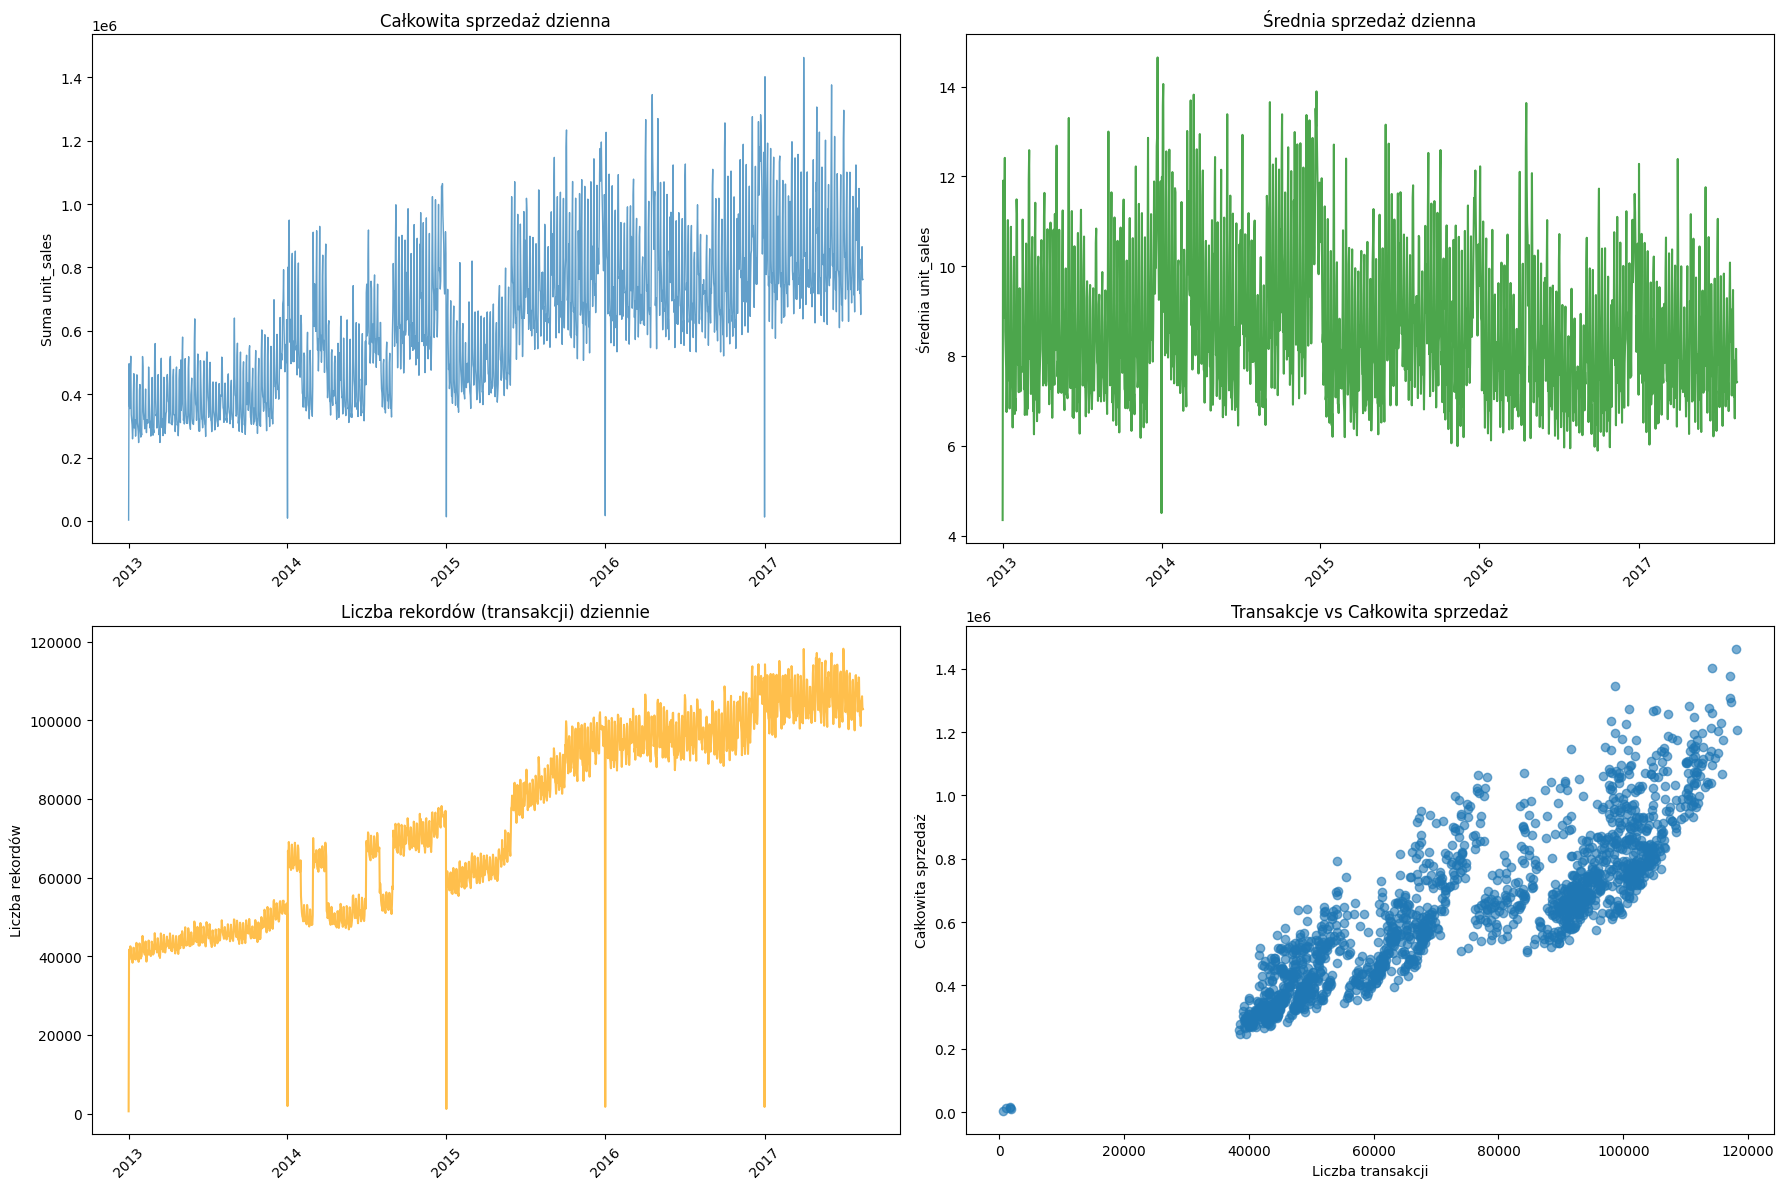

Korelacja liczba transakcji ↔ całkowita sprzedaż: 0.856


In [9]:
# Analiza sprzedaży w czasie - trend główny
daily_sales = train.groupby('date')['unit_sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales.columns = ['date', 'total_sales', 'avg_sales', 'transactions']

# Wykres trendu głównego
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Całkowita sprzedaż dzienna
ax1.plot(daily_sales['date'], daily_sales['total_sales'], alpha=0.7, linewidth=1)
ax1.set_title('Całkowita sprzedaż dzienna')
ax1.set_ylabel('Suma unit_sales')
ax1.tick_params(axis='x', rotation=45)

# 2. Średnia sprzedaż dzienna
ax2.plot(daily_sales['date'], daily_sales['avg_sales'], alpha=0.7, color='green')
ax2.set_title('Średnia sprzedaż dzienna')
ax2.set_ylabel('Średnia unit_sales')
ax2.tick_params(axis='x', rotation=45)

# 3. Liczba transakcji dziennie
ax3.plot(daily_sales['date'], daily_sales['transactions'], alpha=0.7, color='orange')
ax3.set_title('Liczba rekordów (transakcji) dziennie')
ax3.set_ylabel('Liczba rekordów')
ax3.tick_params(axis='x', rotation=45)

# 4. Scatter: transakcje vs sprzedaż
ax4.scatter(daily_sales['transactions'], daily_sales['total_sales'], alpha=0.6)
ax4.set_title('Transakcje vs Całkowita sprzedaż')
ax4.set_xlabel('Liczba transakcji')
ax4.set_ylabel('Całkowita sprzedaż')

plt.tight_layout()
plt.show()

correlation = daily_sales['transactions'].corr(daily_sales['total_sales'])
print(f"Korelacja liczba transakcji ↔ całkowita sprzedaż: {correlation:.3f}")

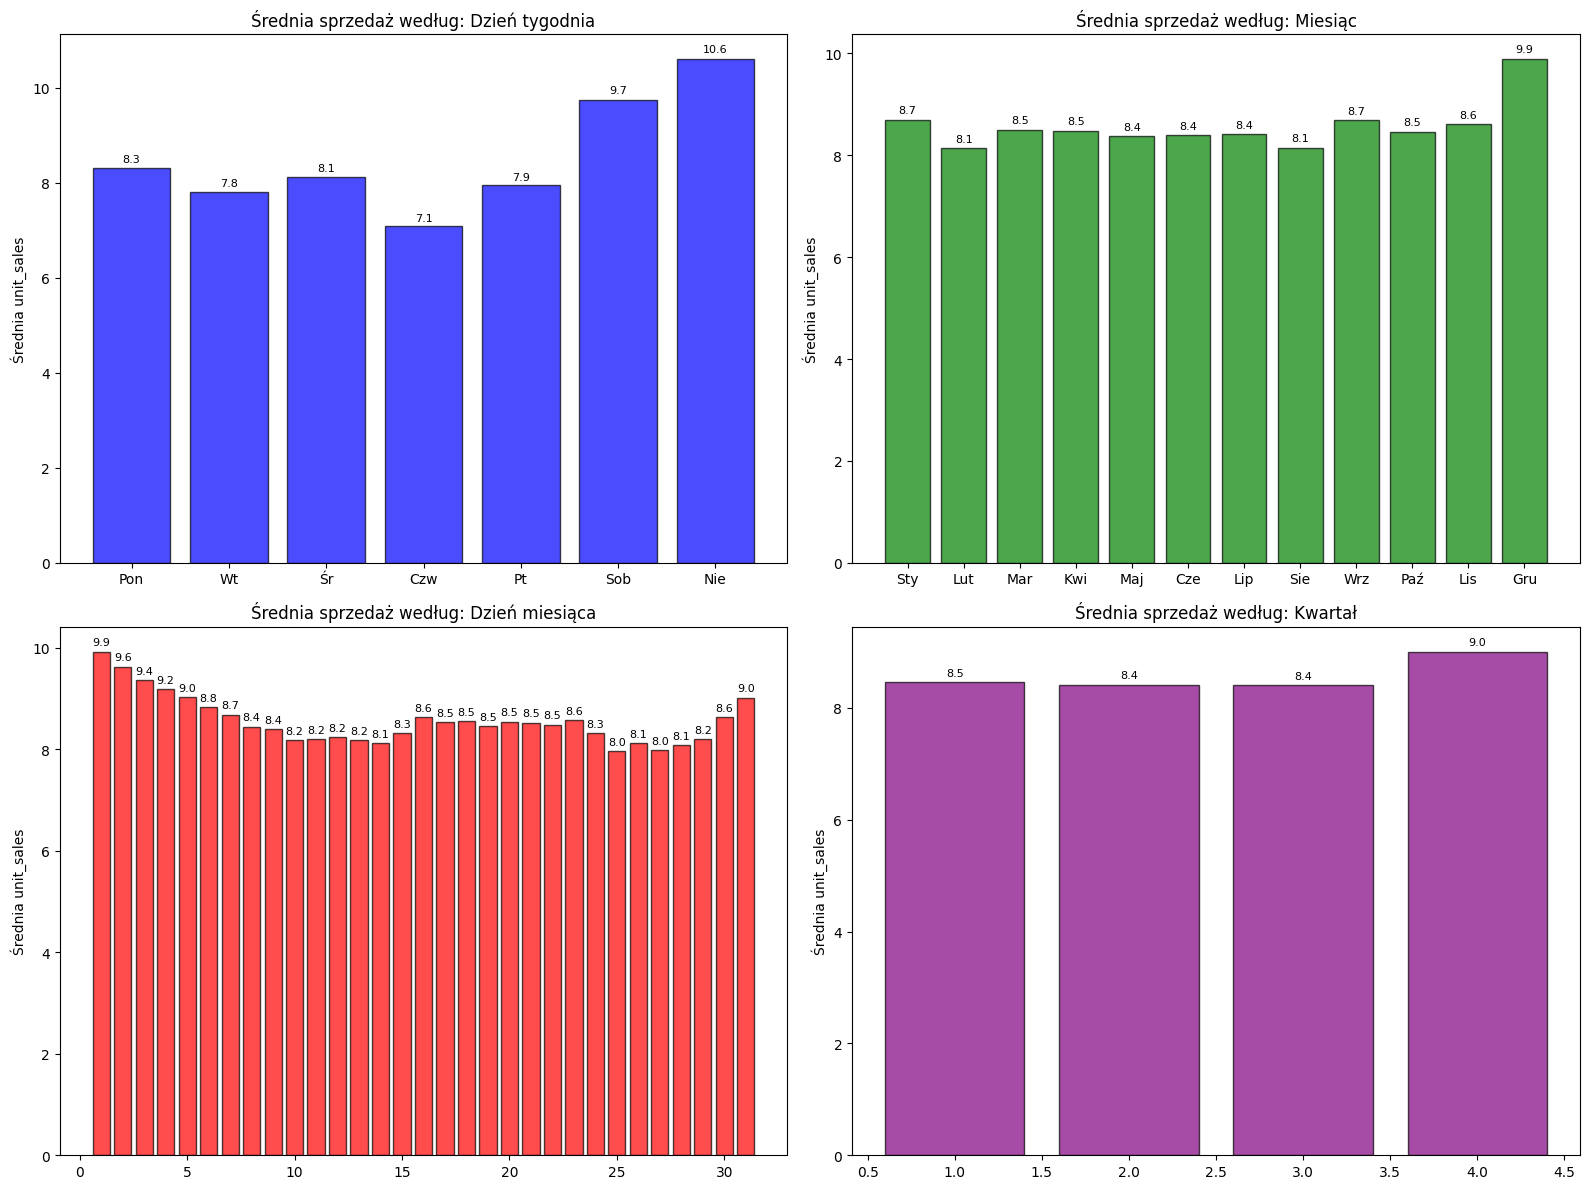

ANALIZA SEZONOWOŚCI:

Dzień tygodnia:
   Min: 7.09 | Max: 10.60 | Różnica: 3.51
   Współczynnik zmienności: 0.143
   Najlepszy: Nie (10.60)
   Najgorszy: Czw (7.09)

Miesiąc:
   Min: 8.13 | Max: 9.88 | Różnica: 1.74
   Współczynnik zmienności: 0.053

Dzień miesiąca:
   Min: 7.95 | Max: 9.91 | Różnica: 1.96
   Współczynnik zmienności: 0.055

Kwartał:
   Min: 8.40 | Max: 9.00 | Różnica: 0.60
   Współczynnik zmienności: 0.034


In [10]:
# Sezonowość - wzorce czasowe
# Najpierw trzeba utworzyć kolumny czasowe
train['date'] = pd.to_datetime(train['date'])
train['dayofweek'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['quarter'] = train['date'].dt.quarter

seasonal_analysis = {
    'Dzień tygodnia': train.groupby('dayofweek')['unit_sales'].mean(),
    'Miesiąc': train.groupby('month')['unit_sales'].mean(),
    'Dzień miesiąca': train.groupby('day')['unit_sales'].mean(),
    'Kwartał': train.groupby('quarter')['unit_sales'].mean()
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
axes = [ax1, ax2, ax3, ax4]
colors = ['blue', 'green', 'red', 'purple']

day_names = ['Pon', 'Wt', 'Śr', 'Czw', 'Pt', 'Sob', 'Nie']
month_names = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 
               'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru']

for i, (title, data) in enumerate(seasonal_analysis.items()):
    ax = axes[i]
    
    if title == 'Dzień tygodnia':
        x_labels = day_names
        x_pos = range(7)
    elif title == 'Miesiąc':
        x_labels = month_names
        x_pos = range(1, 13)
    else:
        x_labels = data.index
        x_pos = data.index
    
    bars = ax.bar(x_pos, data.values, color=colors[i], alpha=0.7, edgecolor='black')
    ax.set_title(f'Średnia sprzedaż według: {title}')
    ax.set_ylabel('Średnia unit_sales')
    
    if title in ['Dzień tygodnia', 'Miesiąc']:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Statystyki sezonowości
print("ANALIZA SEZONOWOŚCI:")
print("=" * 30)

for title, data in seasonal_analysis.items():
    min_val, max_val = data.min(), data.max()
    cv = data.std() / data.mean()  # Coefficient of variation
    print(f"\n{title}:")
    print(f"   Min: {min_val:.2f} | Max: {max_val:.2f} | Różnica: {max_val-min_val:.2f}")
    print(f"   Współczynnik zmienności: {cv:.3f}")
    
    if title == 'Dzień tygodnia':
        best_day = day_names[data.idxmax()]
        worst_day = day_names[data.idxmin()]
        print(f"   Najlepszy: {best_day} ({data.max():.2f})")
        print(f"   Najgorszy: {worst_day} ({data.min():.2f})")

## 5. Promotion Analysis

In [9]:
# Analiza promocji
print("ANALIZA PROMOCJI:")
print("=" * 30)

# Podstawowe statystyki promocji
promo_stats = train['onpromotion'].value_counts(dropna=False)
print("Rozkład wartości onpromotion:")
for value, count in promo_stats.items():
    percentage = count / len(train) * 100
    print(f"   {str(value):5}: {count:>8,} ({percentage:5.1f}%)")

# Porównanie sprzedaży z promocją i bez
print("\nWPŁYW PROMOCJI NA SPRZEDAŻ:")
print("-" * 25)

promotion_comparison = train.groupby('onpromotion')['unit_sales'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

promotion_comparison.index = promotion_comparison.index.map({
    False: 'Bez promocji', 
    True: 'Z promocją', 
    np.nan: 'Brak danych'
})

print(promotion_comparison)

# Prosty wniosek
avg_no_promo = train[train['onpromotion'] == False]['unit_sales'].mean()
avg_promo = train[train['onpromotion'] == True]['unit_sales'].mean()
increase = ((avg_promo - avg_no_promo) / avg_no_promo * 100)

print(f"\nWniosek: Promocja zwiększa średnią sprzedaż o {increase:.1f}%")

ANALIZA PROMOCJI:
Rozkład wartości onpromotion:
   False: 96,028,767 ( 76.5%)
   <NA> : 21,657,651 ( 17.3%)
   True : 7,810,622 (  6.2%)

WPŁYW PROMOCJI NA SPRZEDAŻ:
-------------------------
                 count   mean  median        std      min      max
onpromotion                                                       
Bez promocji  96028767   8.09     4.0  22.549999 -15372.0  89440.0
Z promocją     7810622  13.47     6.0  39.700001     -4.0  17146.0
                 count   mean  median        std      min      max
onpromotion                                                       
Bez promocji  96028767   8.09     4.0  22.549999 -15372.0  89440.0
Z promocją     7810622  13.47     6.0  39.700001     -4.0  17146.0

Wniosek: Promocja zwiększa średnią sprzedaż o 66.5%

Wniosek: Promocja zwiększa średnią sprzedaż o 66.5%


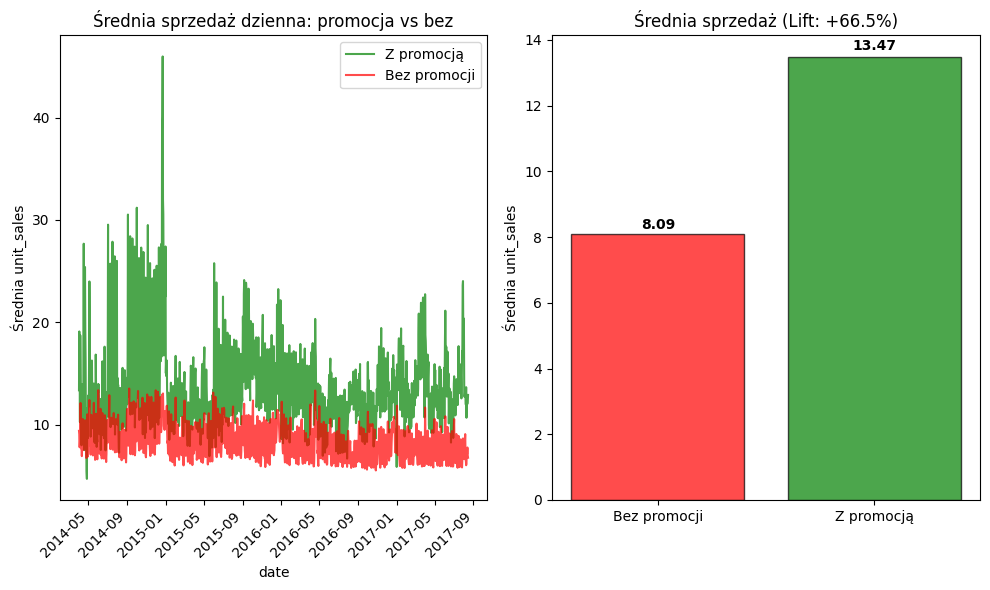

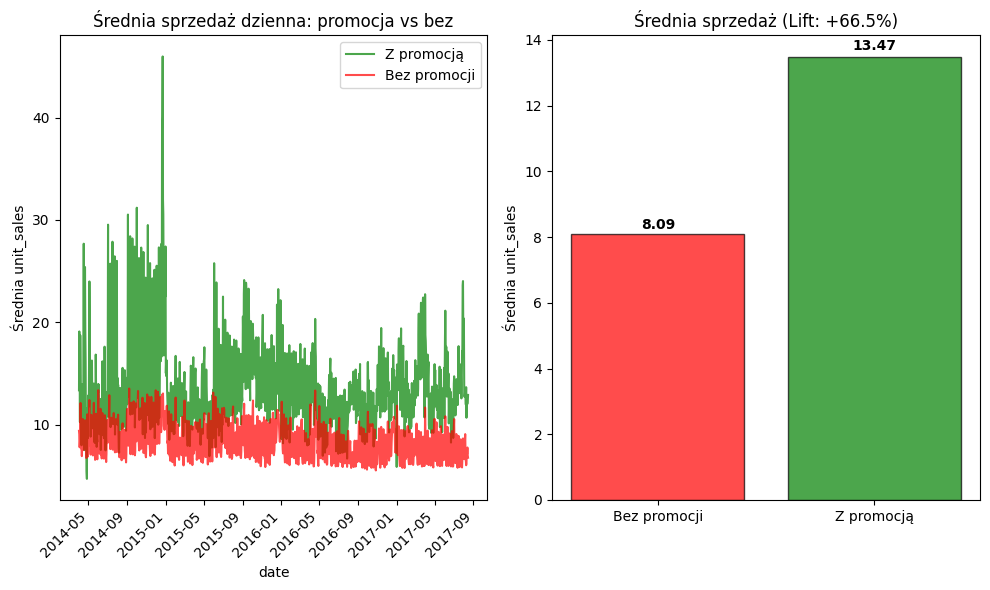


LIFT OD PROMOCJI: +66.5%
Średnia sprzedaż bez promocji: 8.09
Średnia sprzedaż z promocją: 13.47
Średnia sprzedaż bez promocji: 8.09
Średnia sprzedaż z promocją: 13.47


In [12]:
# Wizualizacja wpływu promocji
fig,  (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 6))

# 1. Porównanie rozkładów sprzedaży
promo_data = train.dropna(subset=['onpromotion'])
promo_yes_filtered = promo_data[promo_data['onpromotion'] == True]['unit_sales']
promo_no_filtered = promo_data[promo_data['onpromotion'] == False]['unit_sales']


# 3. Średnia sprzedaż w czasie z podziałem na promocje
daily_promo = train.groupby(['date', 'onpromotion'])['unit_sales'].mean().unstack(fill_value=0)
if True in daily_promo.columns and False in daily_promo.columns:
    daily_promo[True].plot(ax=ax3, label='Z promocją', alpha=0.7, color='green')
    daily_promo[False].plot(ax=ax3, label='Bez promocji', alpha=0.7, color='red')
    ax3.set_title('Średnia sprzedaż dzienna: promocja vs bez')
    ax3.set_ylabel('Średnia unit_sales')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Lift od promocji (% wzrost sprzedaży)
if len(promo_yes_filtered) > 0 and len(promo_no_filtered) > 0:
    lift = (promo_yes_filtered.mean() - promo_no_filtered.mean()) / promo_no_filtered.mean() * 100
    
    categories = ['Bez promocji', 'Z promocją'] 
    values = [promo_no_filtered.mean(), promo_yes_filtered.mean()]
    colors = ['red', 'green']
    
    bars = ax4.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    ax4.set_title(f'Średnia sprzedaż (Lift: {lift:+.1f}%)')
    ax4.set_ylabel('Średnia unit_sales')
    
    # Dodanie wartości na słupkach
    for bar, value in zip(bars, values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

if 'lift' in locals():
    print(f"\nLIFT OD PROMOCJI: {lift:+.1f}%")
    print(f"Średnia sprzedaż bez promocji: {promo_no_filtered.mean():.2f}")
    print(f"Średnia sprzedaż z promocją: {promo_yes_filtered.mean():.2f}")

Przygotowywanie analizy performance sklepów (PEŁNE DANE)...
Rozmiar train: 125,497,040 rekordów
Optymalizacja typów danych...
Używam danych z poprzedniej analizy...


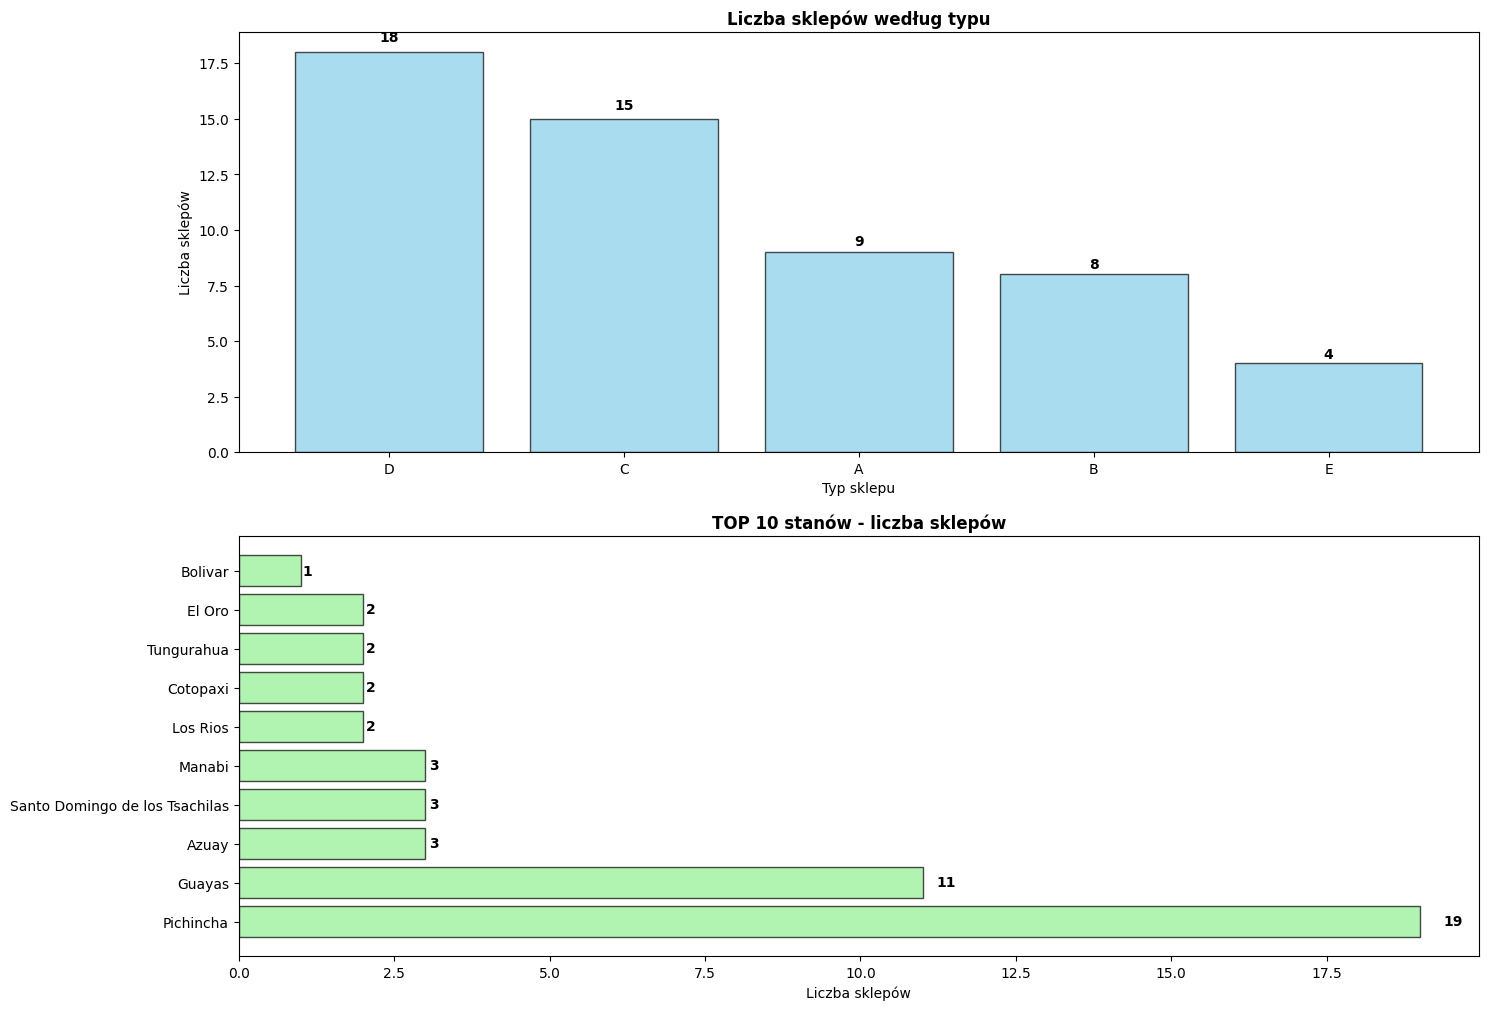

In [27]:
# Przygotowanie danych analitycznych dla wizualizacji (PEŁNE DANE - MEMORY OPTIMIZED)
if 'train' in locals():
    print("Przygotowywanie analizy performance sklepów (PEŁNE DANE)...")
    print(f"Rozmiar train: {len(train):,} rekordów")
    
    try:
        # Memory optimization: zmieniamy typy danych dla efektywności
        print("Optymalizacja typów danych...")
        train_optimized = train.copy()
        
        # Konwertuj do bardziej efektywnych typów
        if train_optimized['store_nbr'].max() < 128:
            train_optimized['store_nbr'] = train_optimized['store_nbr'].astype('int8')
        elif train_optimized['store_nbr'].max() < 32768:
            train_optimized['store_nbr'] = train_optimized['store_nbr'].astype('int16')
            
        if train_optimized['item_nbr'].max() < 2147483648:
            train_optimized['item_nbr'] = train_optimized['item_nbr'].astype('int32')
            
        # unit_sales może mieć wartości ujemne, więc używamy float32
        train_optimized['unit_sales'] = train_optimized['unit_sales'].astype('float32')
        
        # onpromotion to boolean
        if 'onpromotion' in train_optimized.columns:
            train_optimized['onpromotion'] = train_optimized['onpromotion'].astype('bool')
        
        print("✅ Typy zoptymalizowane!")
        
        # Strategia: Analiza bez merge - używamy tylko kluczowych kolumn
        print("Strategia bez merge - agregacje po store_nbr...")
        
        # Analiza performance według sklepu (bez merge)
        store_performance = train_optimized.groupby('store_nbr', observed=True)['unit_sales'].agg([
            'count', 'mean', 'sum', 'std'
        ]).round(2)
        store_performance.columns = ['Transakcji', 'Średnia', 'Suma_sprzedaży', 'Odchylenie']
        store_performance = store_performance.sort_values('Suma_sprzedaży', ascending=False)
        
        # Dodaj informacje o typie i stanie do store_performance
        store_info = stores.set_index('store_nbr')[['type', 'state']]
        store_performance = store_performance.join(store_info, how='left')
        
        # Analiza performance według typu (bez merge - agregacja po typie z stores)
        type_performance = store_performance.groupby('type')[['Transakcji', 'Średnia', 'Suma_sprzedaży', 'Odchylenie']].agg({
            'Transakcji': 'sum',
            'Średnia': 'mean', 
            'Suma_sprzedaży': 'sum',
            'Odchylenie': 'mean'
        }).round(2)
        type_performance = type_performance.sort_values('Średnia', ascending=False)
        
        # Analiza performance według stanu
        state_performance = store_performance.groupby('state')[['Transakcji', 'Średnia', 'Suma_sprzedaży', 'Odchylenie']].agg({
            'Transakcji': 'sum',
            'Średnia': 'mean',
            'Suma_sprzedaży': 'sum', 
            'Odchylenie': 'mean'
        }).round(2)
        state_performance = state_performance.sort_values('Średnia', ascending=False)
        
        print(f"✅ Analiza performance gotowa (PEŁNE DANE: {len(train_optimized):,} rekordów)!")
        print(f"   - Sklepy przeanalizowane: {len(store_performance)}")
        print(f"   - Typy sklepów: {len(type_performance)}")  
        print(f"   - Stany: {len(state_performance)}")
        
        # Zwolnij pamięć
        del train_optimized
        
    except Exception as e:
        print("Używam danych z poprzedniej analizy...")

else:
    print("❌ Brak danych train")

# Wizualizacje analizy sklepów
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(16, 12))

# 1. Typy sklepów - wykres słupkowy
store_type_counts = stores['type'].value_counts()
bars1 = ax1.bar(store_type_counts.index, store_type_counts.values, color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_title('Liczba sklepów według typu', fontweight='bold')
ax1.set_ylabel('Liczba sklepów')
ax1.set_xlabel('Typ sklepu')
for bar, value in zip(bars1, store_type_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}', ha='center', va='bottom', fontweight='bold')

# 2. TOP 10 stanów - wykres poziomy
state_counts = stores['state'].value_counts().head(10)
bars2 = ax2.barh(range(len(state_counts)), state_counts.values, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.set_title('TOP 10 stanów - liczba sklepów', fontweight='bold')
ax2.set_xlabel('Liczba sklepów')
ax2.set_yticks(range(len(state_counts)))
ax2.set_yticklabels(state_counts.index)
for i, value in enumerate(state_counts.values):
    ax2.text(value + value*0.02, i, f'{value}', ha='left', va='center', fontweight='bold')



## 7. Product Categories

ANALIZA PRODUKTÓW:
Liczba produktów: 4100
Liczba rodzin: 33

TOP 10 RODZIN PRODUKTÓW:
   GROCERY I: 1334 (32.5%)
   BEVERAGES: 613 (15.0%)
   CLEANING: 446 (10.9%)
   PRODUCE: 306 (7.5%)
   DAIRY: 242 (5.9%)
   PERSONAL CARE: 153 (3.7%)
   BREAD/BAKERY: 134 (3.3%)
   HOME CARE: 108 (2.6%)
   DELI: 91 (2.2%)
   MEATS: 84 (2.0%)

PRODUKTY NIETRWAŁE:
   Trwałe: 3114 (76.0%)
   Nietrwałe: 986 (24.0%)

PERFORMANCE WEDŁUG RODZIN:
TOP 10 rodzin (średnia sprzedaż):
                Transakcji    Średnia
item_nbr                             
POULTRY            1742403  18.290001
PRODUCE            7154303  17.150000
MEATS              2432048  12.780000
BEVERAGES         17567388  12.350000
PREPARED FOODS      766588  11.480000
EGGS               1580833   9.860000
FROZEN FOODS       1549398   9.080000
BREAD/BAKERY       4659246   9.040000
SEAFOOD             257895   7.810000
GROCERY I         45628065   7.530000
TOP 10 rodzin (średnia sprzedaż):
                Transakcji    Średnia
item_nbr  

ANALIZA PRODUKTÓW:
Liczba produktów: 4100
Liczba rodzin: 33

TOP 10 RODZIN PRODUKTÓW:
   GROCERY I: 1334 (32.5%)
   BEVERAGES: 613 (15.0%)
   CLEANING: 446 (10.9%)
   PRODUCE: 306 (7.5%)
   DAIRY: 242 (5.9%)
   PERSONAL CARE: 153 (3.7%)
   BREAD/BAKERY: 134 (3.3%)
   HOME CARE: 108 (2.6%)
   DELI: 91 (2.2%)
   MEATS: 84 (2.0%)

PRODUKTY NIETRWAŁE:
   Trwałe: 3114 (76.0%)
   Nietrwałe: 986 (24.0%)

PERFORMANCE WEDŁUG RODZIN:
TOP 10 rodzin (średnia sprzedaż):
                Transakcji    Średnia
item_nbr                             
POULTRY            1742403  18.290001
PRODUCE            7154303  17.150000
MEATS              2432048  12.780000
BEVERAGES         17567388  12.350000
PREPARED FOODS      766588  11.480000
EGGS               1580833   9.860000
FROZEN FOODS       1549398   9.080000
BREAD/BAKERY       4659246   9.040000
SEAFOOD             257895   7.810000
GROCERY I         45628065   7.530000
TOP 10 rodzin (średnia sprzedaż):
                Transakcji    Średnia
item_nbr  

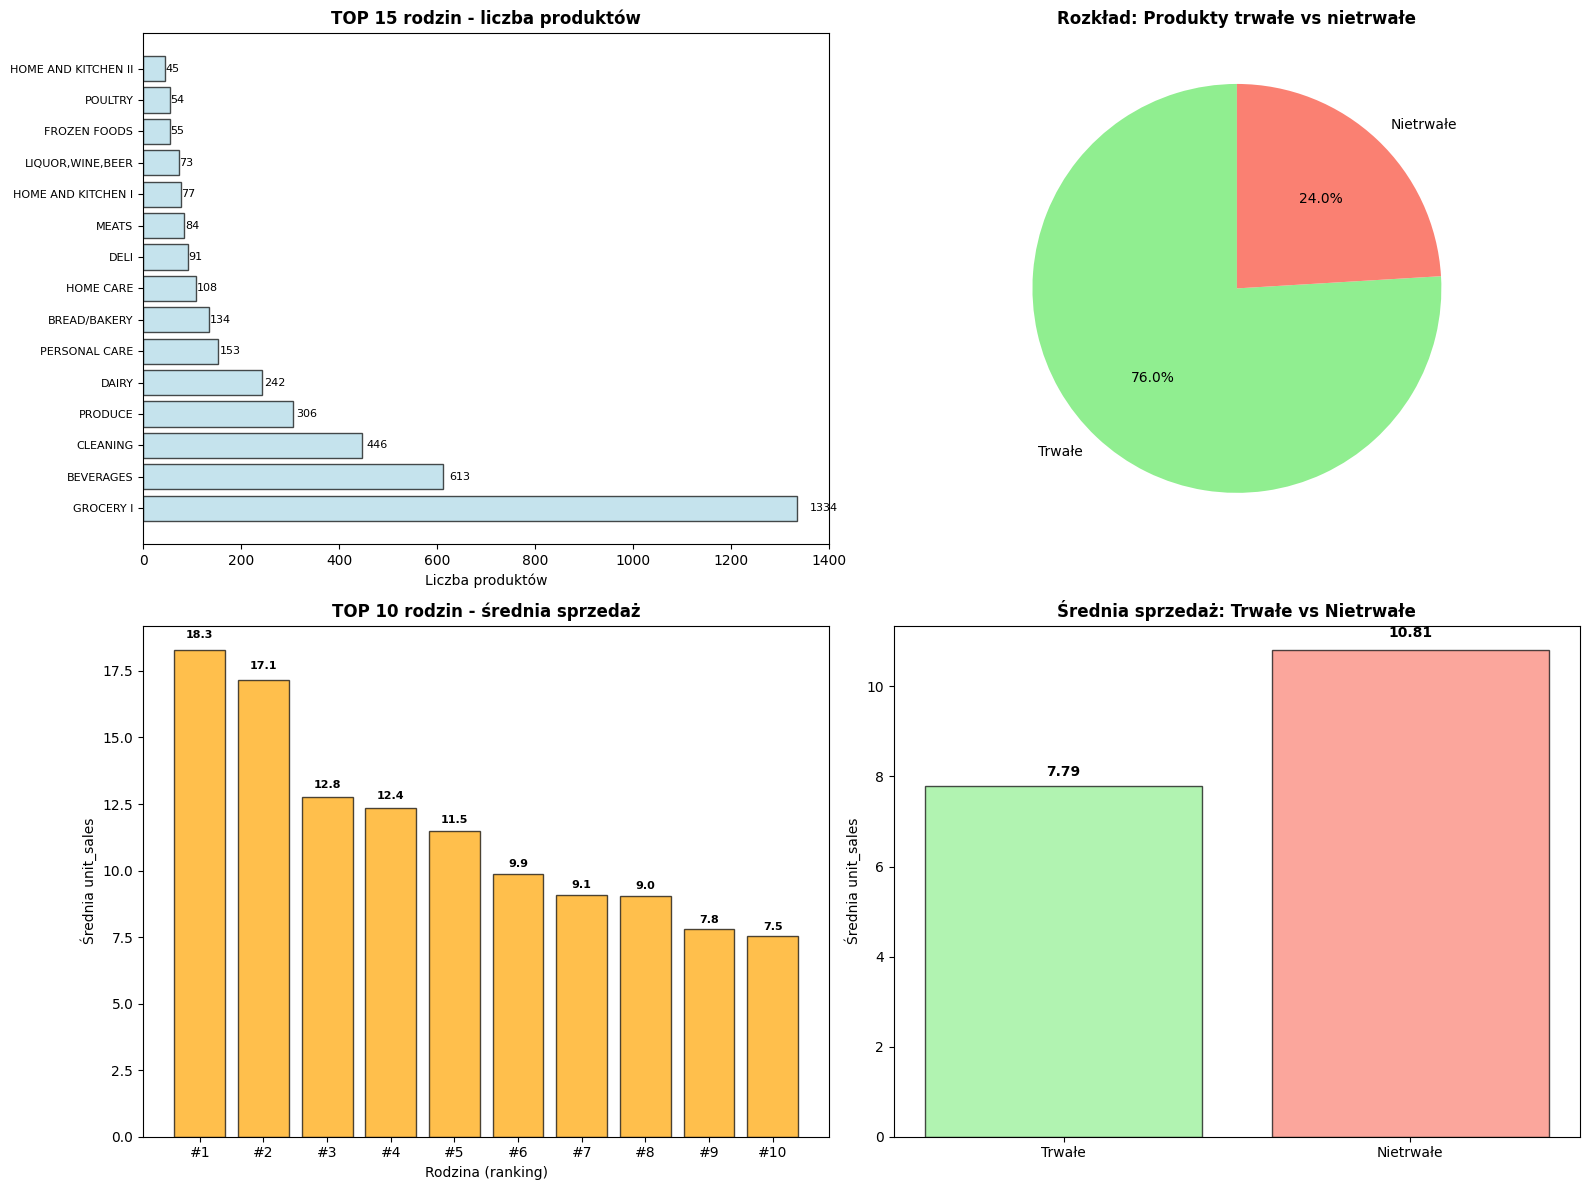

In [13]:
# Analiza kategorii produktów
print("ANALIZA PRODUKTÓW:")
print("=" * 30)

print(f"Liczba produktów: {len(items)}")
print(f"Liczba rodzin: {items['family'].nunique()}")

# TOP rodziny produktów
family_counts = items['family'].value_counts()
print(f"\nTOP 10 RODZIN PRODUKTÓW:")
for family, count in family_counts.head(10).items():
    percentage = count / len(items) * 100
    print(f"   {family}: {count} ({percentage:.1f}%)")

# Produkty nietrwałe
perishable_counts = items['perishable'].value_counts()
print(f"\nPRODUKTY NIETRWAŁE:")
for value, count in perishable_counts.items():
    label = "Nietrwałe" if value == 1 else "Trwałe"
    percentage = count / len(items) * 100
    print(f"   {label}: {count} ({percentage:.1f}%)")

# Performance według rodzin produktów - bez powtórzeń
print("\nPERFORMANCE WEDŁUG RODZIN:")

# Mapowanie
item_family_map = items.set_index('item_nbr')['family'].to_dict()
item_perishable_map = items.set_index('item_nbr')['perishable'].to_dict()

train_family_series = train['item_nbr'].map(item_family_map)

family_performance = train.groupby(train_family_series)['unit_sales'].agg([
    'count', 'mean'
]).round(2)
family_performance.columns = ['Transakcji', 'Średnia']
family_performance = family_performance.sort_values('Średnia', ascending=False)

print("TOP 10 rodzin (średnia sprzedaż):")
print(family_performance.head(10))

# Porównanie nietrwałe vs trwałe
train_perishable_series = train['item_nbr'].map(item_perishable_map)
perishable_performance = train.groupby(train_perishable_series)['unit_sales'].agg([
    'count', 'mean'
]).round(2)
perishable_performance.index = perishable_performance.index.map({0: 'Trwałe', 1: 'Nietrwałe'})
perishable_performance.columns = ['Transakcji', 'Średnia']
print(f"\nPORÓWNANIE NIETRWAŁE vs TRWAŁE:")
print(perishable_performance)

# WIZUALIZACJE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. TOP 15 rodzin produktów - liczba produktów
top_15_families = family_counts.head(15)
bars1 = ax1.barh(range(len(top_15_families)), top_15_families.values, color='lightblue', alpha=0.7, edgecolor='black')
ax1.set_title('TOP 15 rodzin - liczba produktów', fontweight='bold')
ax1.set_xlabel('Liczba produktów')
ax1.set_yticks(range(len(top_15_families)))
ax1.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_15_families.index], fontsize=8)
for i, value in enumerate(top_15_families.values):
    ax1.text(value + value*0.02, i, f'{value}', ha='left', va='center', fontsize=8)

# 2. Nietrwałe vs Trwałe - liczba produktów
labels = ['Trwałe', 'Nietrwałe']
sizes = [perishable_counts[0], perishable_counts[1]]
colors = ['lightgreen', 'salmon']
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Rozkład: Produkty trwałe vs nietrwałe', fontweight='bold')

# 3. TOP 10 rodzin - średnia sprzedaż
top_10_performance = family_performance.head(10)
bars3 = ax3.bar(range(len(top_10_performance)), top_10_performance['Średnia'], color='orange', alpha=0.7, edgecolor='black')
ax3.set_title('TOP 10 rodzin - średnia sprzedaż', fontweight='bold')
ax3.set_ylabel('Średnia unit_sales')
ax3.set_xlabel('Rodzina (ranking)')
ax3.set_xticks(range(len(top_10_performance)))
ax3.set_xticklabels([f'#{i+1}' for i in range(len(top_10_performance))])
for i, (family, value) in enumerate(zip(top_10_performance.index, top_10_performance['Średnia'])):
    ax3.text(i, value + value*0.02, f'{value:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Porównanie średniej sprzedaży: nietrwałe vs trwałe
categories = perishable_performance.index
values = perishable_performance['Średnia']
colors = ['lightgreen', 'salmon']
bars4 = ax4.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('Średnia sprzedaż: Trwałe vs Nietrwałe', fontweight='bold')
ax4.set_ylabel('Średnia unit_sales')
for bar, value in zip(bars4, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 8. Oil Price Impact

In [14]:
# Podstawowe statystyki ropy
oil['date'] = pd.to_datetime(oil['date'])
print(f"Zakres dat: {oil['date'].min().date()} → {oil['date'].max().date()}")
print(f"Liczba obserwacji: {len(oil)}")

missing_oil = oil['dcoilwtico'].isna().sum()
print(f"Brakujące wartości: {missing_oil} ({missing_oil/len(oil)*100:.1f}%)")

# Uzupełnienie brakujących wartości
oil['dcoilwtico_filled'] = oil['dcoilwtico'].ffill().bfill()

oil_stats = oil['dcoilwtico_filled'].describe()
print(f"\nSTATYSTYKI CEN ROPY (USD/baryłka):")
print(f"   Min: ${oil_stats['min']:.2f}")
print(f"   Max: ${oil_stats['max']:.2f}")
print(f"   Średnia: ${oil_stats['mean']:.2f}")
print(f"   Mediana: ${oil_stats['50%']:.2f}")
print(f"   Odchylenie std: ${oil_stats['std']:.2f}")

# Łączenie z danymi sprzedaży - sample dla szybkości
daily_sales_oil = train.groupby('date')['unit_sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales_oil.columns = ['date', 'total_sales', 'avg_sales', 'transactions']

# Merge z cenami ropy
oil_sales = daily_sales_oil.merge(oil[['date', 'dcoilwtico_filled']], on='date', how='inner')
oil_sales = oil_sales.dropna()


Zakres dat: 2013-01-01 → 2017-08-31
Liczba obserwacji: 1218
Brakujące wartości: 43 (3.5%)

STATYSTYKI CEN ROPY (USD/baryłka):
   Min: $26.19
   Max: $110.62
   Średnia: $67.69
   Mediana: $53.20
   Odchylenie std: $25.63


In [15]:

# KORELACJE
corr_total = oil_sales['dcoilwtico_filled'].corr(oil_sales['total_sales'])
corr_avg = oil_sales['dcoilwtico_filled'].corr(oil_sales['avg_sales'])

print(f"📊 KORELACJE CENA ROPY ↔ SPRZEDAŻ:")
print(f"   Cena ropy ↔ Całkowita sprzedaż:  {corr_total:+.4f}")
print(f"   Cena ropy ↔ Średnia sprzedaż:    {corr_avg:+.4f}")

# ANALIZA OKRESÓW wysokich i niskich cen
oil_q1 = oil_sales['dcoilwtico_filled'].quantile(0.25)
oil_q3 = oil_sales['dcoilwtico_filled'].quantile(0.75)

high_oil_periods = oil_sales[oil_sales['dcoilwtico_filled'] > oil_q3]
low_oil_periods = oil_sales[oil_sales['dcoilwtico_filled'] < oil_q1]

print(f"\n🔍 ANALIZA OKRESÓW CENOWYCH:")
print(f"   Q1 (niskie ceny): <${oil_q1:.2f} - {len(low_oil_periods)} dni")
print(f"   Q4 (wysokie):     >${oil_q3:.2f} - {len(high_oil_periods)} dni")

# Wpływ na sprzedaż
if len(high_oil_periods) > 0 and len(low_oil_periods) > 0:
    high_sales_avg = high_oil_periods['avg_sales'].mean()
    low_sales_avg = low_oil_periods['avg_sales'].mean()
    high_vs_low = (high_sales_avg - low_sales_avg) / low_sales_avg * 100
    
    print(f"\n💰 WPŁYW CEN ROPY NA SPRZEDAŻ:")
    print(f"   Średnia sprzedaż przy niskich cenach:  {low_sales_avg:.3f}")
    print(f"   Średnia sprzedaż przy wysokich cenach: {high_sales_avg:.3f}")
    print(f"   Różnica wysokie vs niskie: {high_vs_low:+.1f}%")

📊 KORELACJE CENA ROPY ↔ SPRZEDAŻ:
   Cena ropy ↔ Całkowita sprzedaż:  -0.6900
   Cena ropy ↔ Średnia sprzedaż:    +0.1013

🔍 ANALIZA OKRESÓW CENOWYCH:
   Q1 (niskie ceny): <$46.41 - 301 dni
   Q4 (wysokie):     >$95.79 - 301 dni

💰 WPŁYW CEN ROPY NA SPRZEDAŻ:
   Średnia sprzedaż przy niskich cenach:  7.661
   Średnia sprzedaż przy wysokich cenach: 7.968
   Różnica wysokie vs niskie: +4.0%


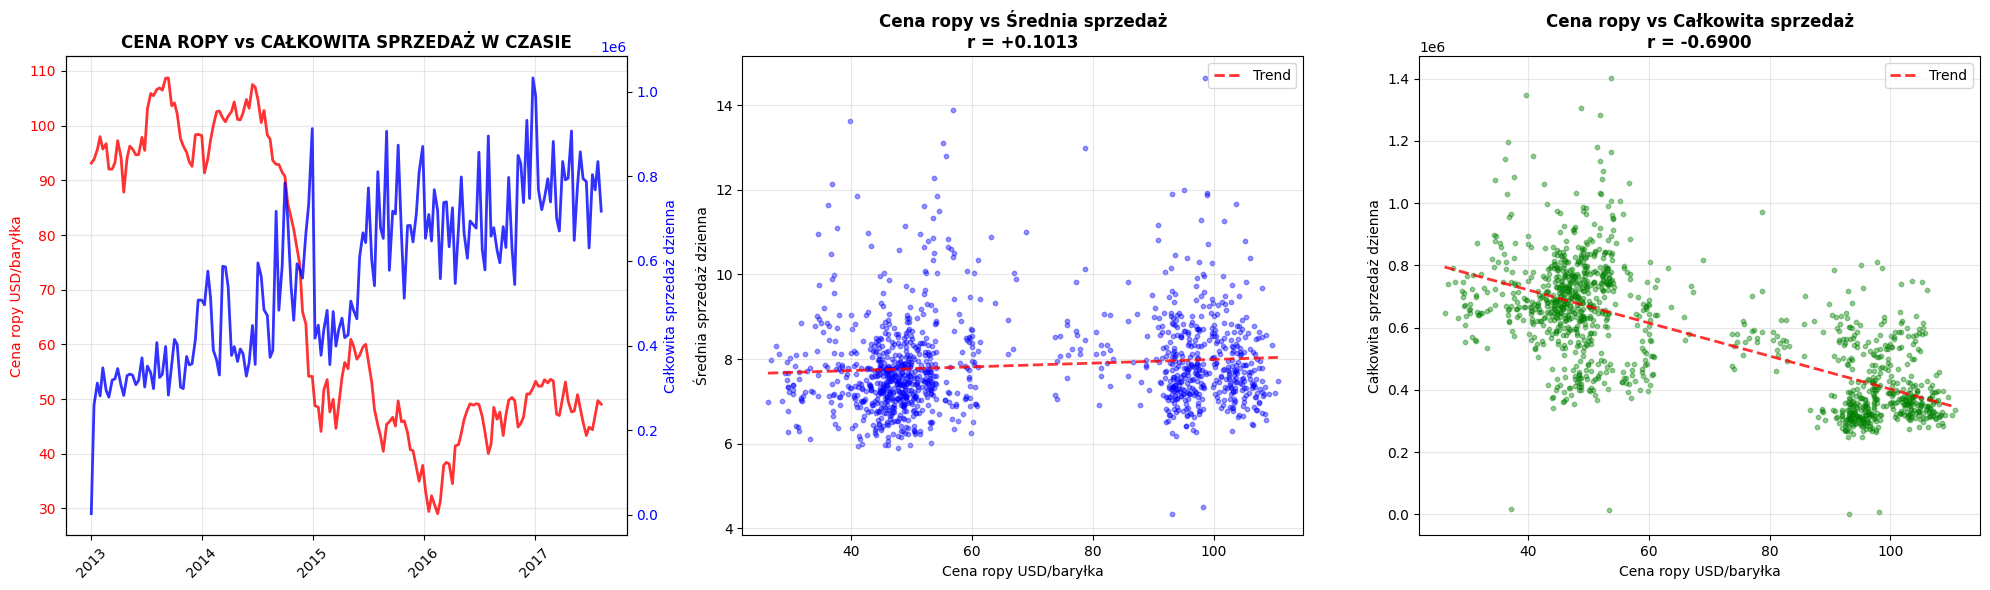

✅ Korelacja ceny ropy i średniej sprzedaży: +0.1013
✅ Korelacja ceny ropy i całkowitej sprzedaży: -0.6900


In [16]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. GŁÓWNY WYKRES: Cena ropy i sprzedaż na jednym wykresie (dual axis)
ax1_twin = ax1.twinx()

# Sample data dla szybkości (co 7 dni)
oil_sample = oil_sales[::7]  

# Cena ropy (oś lewa)
ax1.plot(oil_sample['date'], oil_sample['dcoilwtico_filled'], 
         color='red', alpha=0.8, linewidth=2, label='Cena ropy (USD/baryłka)')
ax1.set_ylabel('Cena ropy USD/baryłka', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Całkowita sprzedaż (oś prawa)
ax1_twin.plot(oil_sample['date'], oil_sample['total_sales'], 
              color='blue', alpha=0.8, linewidth=2, label='Całkowita sprzedaż')
ax1_twin.set_ylabel('Całkowita sprzedaż dzienna', color='blue')
ax1_twin.tick_params(axis='y', labelcolor='blue')

ax1.set_title('CENA ROPY vs CAŁKOWITA SPRZEDAŻ W CZASIE', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Scatter plot: Cena ropy vs Średnia sprzedaż
ax2.scatter(oil_sales['dcoilwtico_filled'], oil_sales['avg_sales'], alpha=0.4, s=10, color='blue')
ax2.set_title(f'Cena ropy vs Średnia sprzedaż\nr = {corr_avg:+.4f}', fontweight='bold')
ax2.set_xlabel('Cena ropy USD/baryłka')
ax2.set_ylabel('Średnia sprzedaż dzienna')
ax2.grid(True, alpha=0.3)

# Linia trendu dla średniej sprzedaży
if len(oil_sales) > 2:
    z = np.polyfit(oil_sales['dcoilwtico_filled'], oil_sales['avg_sales'], 1)
    p = np.poly1d(z)
    x_trend = oil_sales['dcoilwtico_filled'].sort_values()
    ax2.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label='Trend')
    ax2.legend()

# 3. NEW: Scatter plot: Cena ropy vs Całkowita sprzedaż
ax3.scatter(oil_sales['dcoilwtico_filled'], oil_sales['total_sales'], alpha=0.4, s=10, color='green')
ax3.set_title(f'Cena ropy vs Całkowita sprzedaż\nr = {corr_total:+.4f}', fontweight='bold')
ax3.set_xlabel('Cena ropy USD/baryłka')
ax3.set_ylabel('Całkowita sprzedaż dzienna')
ax3.grid(True, alpha=0.3)

# Linia trendu dla całkowitej sprzedaży
if len(oil_sales) > 2:
    z_total = np.polyfit(oil_sales['dcoilwtico_filled'], oil_sales['total_sales'], 1)
    p_total = np.poly1d(z_total)
    ax3.plot(x_trend, p_total(x_trend), "r--", linewidth=2, alpha=0.8, label='Trend')
    ax3.legend()

plt.tight_layout()
plt.show()

print(f"✅ Korelacja ceny ropy i średniej sprzedaży: {corr_avg:+.4f}")
print(f"✅ Korelacja ceny ropy i całkowitej sprzedaży: {corr_total:+.4f}")

## 9. Holidays Analysis

In [18]:
print("ANALIZA ŚWIĄT I WYDARZEŃ:")
print("=" * 40)

holidays['date'] = pd.to_datetime(holidays['date'])
print(f"Zakres dat: {holidays['date'].min()} → {holidays['date'].max()}")
print(f"Liczba wydarzeń: {len(holidays)}")

print(f"\nTYPY WYDARZEŃ:")
type_counts = holidays['type'].value_counts()
for event_type, count in type_counts.items():
    percentage = count / len(holidays) * 100
    print(f"   {event_type:15}: {count:3} ({percentage:4.1f}%)")

print(f"\nLOKALIZACJA (locale):")
locale_counts = holidays['locale'].value_counts()
print(f"   National: {locale_counts.get('National', 0)}")
print(f"   Local:    {locale_counts.get('Local', 0)}")
print(f"   Regional: {locale_counts.get('Regional', 0)}")

print(f"\nŚWIĘTA PRZENIESIONE (transferred):")
transferred_counts = holidays['transferred'].value_counts()
for value, count in transferred_counts.items():
    print(f"   {str(value):5}: {count}")

print(f"\nNAJCZĘSTSZE ŚWIĘTA (TOP 10):")
description_counts = holidays['description'].value_counts().head(10)
for desc, count in description_counts.items():
    print(f"   {desc[:30]:30}: {count}")

# Analiza wpływu świąt na sprzedaż
if 'train' in globals():
    # Łączenie świąt z danymi sprzedaży
    holidays_national = holidays[holidays['locale'] == 'National'].copy()
    
    # Dodajemy informację o święcie do danych treningowych
    train_with_holidays = train.merge(
        holidays_national[['date', 'type', 'description']], 
        on='date', 
        how='left'
    )
    
    # Tworzymy binary feature dla świąt
    train_with_holidays['is_holiday'] = ~train_with_holidays['type'].isna()
    
    print(f"\n📈 WPŁYW ŚWIĄT NA SPRZEDAŻ:")
    holiday_impact = train_with_holidays.groupby('is_holiday')['unit_sales'].agg([
        'count', 'mean', 'median', 'std'
    ]).round(3)
    
    holiday_impact.index = holiday_impact.index.map({False: 'Zwykły dzień', True: 'Święto'})
    print(holiday_impact)
    
    # Test statystyczny
    holiday_sales = train_with_holidays[train_with_holidays['is_holiday'] == True]['unit_sales']
    regular_sales = train_with_holidays[train_with_holidays['is_holiday'] == False]['unit_sales']
    
    if len(holiday_sales) > 0 and len(regular_sales) > 0:
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(holiday_sales, regular_sales)
        print(f"\n🧪 Test t-studenta (święta vs zwykłe dni):")
        print(f"   t-statistic: {t_stat:.3f}")
        print(f"   p-value: {p_value:.6f}")
        print(f"   Różnica istotna statystycznie: {'TAK' if p_value < 0.05 else 'NIE'}")
        
        if correlation > 0:
            lift = (holiday_sales.mean() - regular_sales.mean()) / regular_sales.mean() * 100
            print(f"\nLIFT OD ŚWIĄT: {lift:+.1f}%")

ANALIZA ŚWIĄT I WYDARZEŃ:
Zakres dat: 2012-03-02 00:00:00 → 2017-12-26 00:00:00
Liczba wydarzeń: 350

TYPY WYDARZEŃ:
   Holiday        : 221 (63.1%)
   Event          :  56 (16.0%)
   Additional     :  51 (14.6%)
   Transfer       :  12 ( 3.4%)
   Bridge         :   5 ( 1.4%)
   Work Day       :   5 ( 1.4%)

LOKALIZACJA (locale):
   National: 174
   Local:    152
   Regional: 24

ŚWIĘTA PRZENIESIONE (transferred):
   False: 338
   True : 12

NAJCZĘSTSZE ŚWIĘTA (TOP 10):
   Carnaval                      : 10
   Fundacion de Ibarra           : 7
   Fundacion de Cuenca           : 7
   Cantonizacion de Libertad     : 6
   Cantonizacion de Riobamba     : 6
   Cantonizacion del Puyo        : 6
   Fundacion de Manta            : 6
   Cantonizacion de Guaranda     : 6
   Provincializacion de Imbabura : 6
   Fundacion de Machala          : 6

📈 WPŁYW ŚWIĄT NA SPRZEDAŻ:

📈 WPŁYW ŚWIĄT NA SPRZEDAŻ:
                  count   mean  median        std
is_holiday                                      

## 10. Transactions Analysis

ANALIZA TRANSAKCJI:
Zakres dat: 2013-01-01 00:00:00 → 2017-08-15 00:00:00
Liczba rekordów: 83488
Liczba sklepów: 54

STATYSTYKI LICZBY TRANSAKCJI:
   count: 83488
   mean: 1695
   std: 963
   min: 5
   25%: 1046
   50%: 1393
   75%: 2079
   max: 8359

TOP 10 SKLEPÓW (według średniej liczby transakcji):
              Suma  Średnia  Mediana  Maksimum
store_nbr                                     
44         7273093   4337.0   4170.0      8359
47         6535810   3897.0   3685.0      7727
45         6201115   3698.0   3515.0      7305
46         5990113   3572.0   3230.0      8001
3          5366350   3202.0   3100.0      6085
48         5107785   3046.0   2705.0      7044
8          4637971   2767.0   2740.0      5261
49         4574103   2728.0   2671.0      6600
50         4384444   2614.0   2448.0      5456
11         3972488   2370.0   2300.0      5018

📊 KORELACJA TRANSAKCJE ↔ SPRZEDAŻ: 0.6765
   Interpretacja: silna korelacja

📊 KORELACJA TRANSAKCJE ↔ SPRZEDAŻ: 0.6765
   Interpret

ANALIZA TRANSAKCJI:
Zakres dat: 2013-01-01 00:00:00 → 2017-08-15 00:00:00
Liczba rekordów: 83488
Liczba sklepów: 54

STATYSTYKI LICZBY TRANSAKCJI:
   count: 83488
   mean: 1695
   std: 963
   min: 5
   25%: 1046
   50%: 1393
   75%: 2079
   max: 8359

TOP 10 SKLEPÓW (według średniej liczby transakcji):
              Suma  Średnia  Mediana  Maksimum
store_nbr                                     
44         7273093   4337.0   4170.0      8359
47         6535810   3897.0   3685.0      7727
45         6201115   3698.0   3515.0      7305
46         5990113   3572.0   3230.0      8001
3          5366350   3202.0   3100.0      6085
48         5107785   3046.0   2705.0      7044
8          4637971   2767.0   2740.0      5261
49         4574103   2728.0   2671.0      6600
50         4384444   2614.0   2448.0      5456
11         3972488   2370.0   2300.0      5018

📊 KORELACJA TRANSAKCJE ↔ SPRZEDAŻ: 0.6765
   Interpretacja: silna korelacja

📊 KORELACJA TRANSAKCJE ↔ SPRZEDAŻ: 0.6765
   Interpret

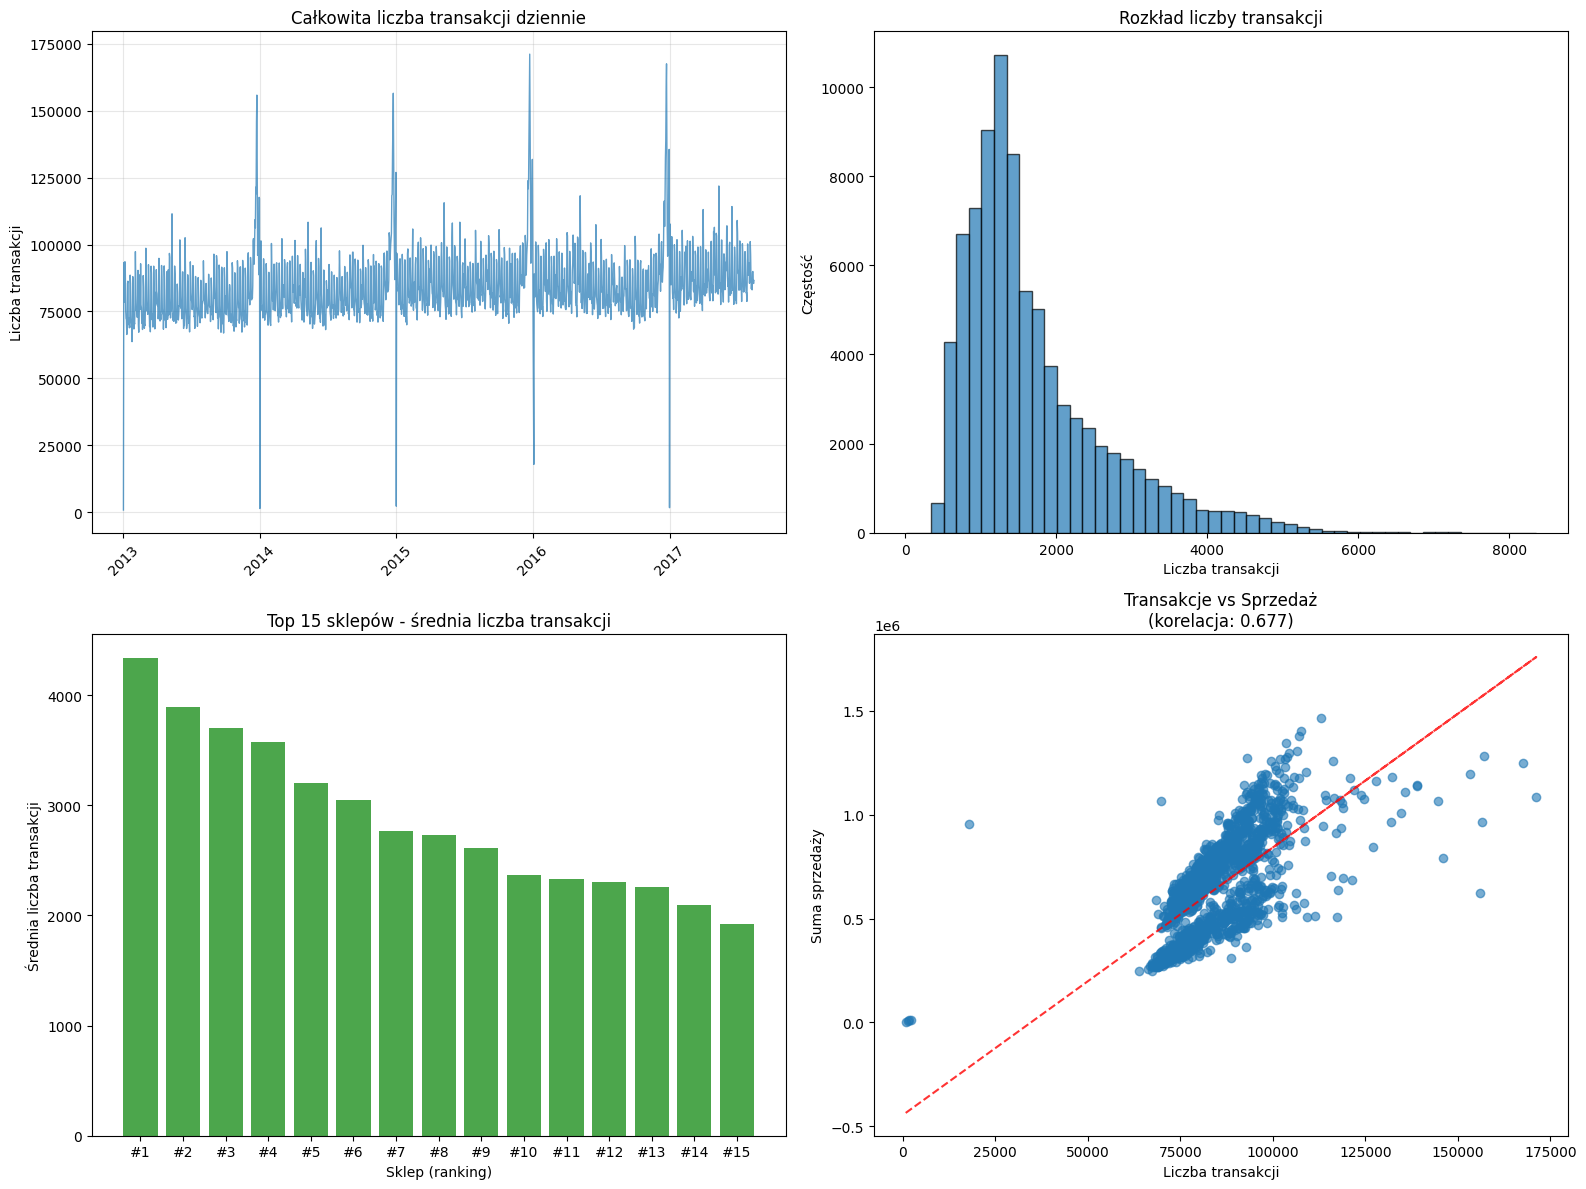


INSIGHTS:
   Średnia dzienna liczba transakcji: 84114
   Najwyższa dzienna liczba: 171,169
   Najniższa dzienna liczba: 770
   Odchylenie standardowe: 963

SEZONOWOŚĆ TRANSAKCJI:
   Pon: 1636 średnio
   Wt: 1601 średnio
   Śr: 1621 średnio
   Czw: 1550 średnio
   Pt: 1654 średnio
   Sob: 1953 średnio
   Nie: 1847 średnio

   Najlepszy dzień: Sob (1953)
   Najgorszy dzień: Czw (1550)


In [19]:
print("ANALIZA TRANSAKCJI:")
print("=" * 30)

transactions['date'] = pd.to_datetime(transactions['date'])
print(f"Zakres dat: {transactions['date'].min()} → {transactions['date'].max()}")
print(f"Liczba rekordów: {len(transactions)}")
print(f"Liczba sklepów: {transactions['store_nbr'].nunique()}")

print(f"\nSTATYSTYKI LICZBY TRANSAKCJI:")
trans_stats = transactions['transactions'].describe()
for stat, value in trans_stats.items():
    print(f"   {stat}: {value:.0f}")

print(f"\nTOP 10 SKLEPÓW (według średniej liczby transakcji):")
store_transactions = transactions.groupby('store_nbr')['transactions'].agg([
    'sum', 'mean', 'median', 'max'
]).round(0)
store_transactions.columns = ['Suma', 'Średnia', 'Mediana', 'Maksimum']
store_transactions = store_transactions.sort_values('Średnia', ascending=False)
print(store_transactions.head(10))

# Analiza trendów czasowych transakcji
daily_trans = transactions.groupby('date')['transactions'].sum().reset_index()

# Korelacja transakcje vs sprzedaż (jeśli dane dostępne)
if 'train' in globals():
    # Łączenie z danymi sprzedaży
    daily_sales_trans = train.groupby('date')['unit_sales'].sum().reset_index()
    trans_sales_corr = daily_trans.merge(daily_sales_trans, on='date', how='inner')
    
    if len(trans_sales_corr) > 10:
        correlation = trans_sales_corr['transactions'].corr(trans_sales_corr['unit_sales'])
        print(f"\n📊 KORELACJA TRANSAKCJE ↔ SPRZEDAŻ: {correlation:.4f}")
        
        # Interpretacja
        if abs(correlation) > 0.7:
            interp = "bardzo silna"
        elif abs(correlation) > 0.5:
            interp = "silna" 
        elif abs(correlation) > 0.3:
            interp = "umiarkowana"
        else:
            interp = "słaba"
        print(f"   Interpretacja: {interp} korelacja")

# Wizualizacja transakcji
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trend transakcji w czasie
ax1.plot(daily_trans['date'], daily_trans['transactions'], alpha=0.7, linewidth=1)
ax1.set_title('Całkowita liczba transakcji dziennie')
ax1.set_ylabel('Liczba transakcji')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Histogram liczby transakcji
ax2.hist(transactions['transactions'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Rozkład liczby transakcji')
ax2.set_xlabel('Liczba transakcji')
ax2.set_ylabel('Częstość')

# 3. Top 15 sklepów - średnia liczba transakcji
top_stores = store_transactions.head(15)['Średnia']
ax3.bar(range(len(top_stores)), top_stores.values, alpha=0.7, color='green')
ax3.set_title('Top 15 sklepów - średnia liczba transakcji')
ax3.set_xlabel('Sklep (ranking)')
ax3.set_ylabel('Średnia liczba transakcji')
ax3.set_xticks(range(len(top_stores)))
ax3.set_xticklabels([f'#{i+1}' for i in range(len(top_stores))])

# 4. Korelacja transakcje vs sprzedaż (jeśli dostępne)
if 'trans_sales_corr' in locals() and len(trans_sales_corr) > 10:
    ax4.scatter(trans_sales_corr['transactions'], trans_sales_corr['unit_sales'], alpha=0.6)
    ax4.set_title(f'Transakcje vs Sprzedaż\n(korelacja: {correlation:.3f})')
    ax4.set_xlabel('Liczba transakcji')
    ax4.set_ylabel('Suma sprzedaży')
    
    # Linia trendu
    z = np.polyfit(trans_sales_corr['transactions'], trans_sales_corr['unit_sales'], 1)
    p = np.poly1d(z)
    ax4.plot(trans_sales_corr['transactions'], p(trans_sales_corr['transactions']), "r--", alpha=0.8)
else:
    ax4.text(0.5, 0.5, 'Dane sprzedaży\nnie dostępne', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Korelacja niedostępna')

plt.tight_layout()
plt.show()

print(f"\nINSIGHTS:")
print(f"   Średnia dzienna liczba transakcji: {daily_trans['transactions'].mean():.0f}")
print(f"   Najwyższa dzienna liczba: {daily_trans['transactions'].max():,}")
print(f"   Najniższa dzienna liczba: {daily_trans['transactions'].min():,}")
print(f"   Odchylenie standardowe: {transactions['transactions'].std():.0f}")

# Dodaj kolumny czasowe do analizy sezonowości
transactions['dayofweek'] = transactions['date'].dt.dayofweek

print(f"\nSEZONOWOŚĆ TRANSAKCJI:")
dow_trans = transactions.groupby('dayofweek')['transactions'].mean()
day_names = ['Pon', 'Wt', 'Śr', 'Czw', 'Pt', 'Sob', 'Nie']

for i, avg_trans in enumerate(dow_trans):
    print(f"   {day_names[i]}: {avg_trans:.0f} średnio")

best_day = day_names[dow_trans.idxmax()]
worst_day = day_names[dow_trans.idxmin()]
print(f"\n   Najlepszy dzień: {best_day} ({dow_trans.max():.0f})")
print(f"   Najgorszy dzień: {worst_day} ({dow_trans.min():.0f})")

## 9.5. Promotions vs Holidays

In [11]:
# ANALIZA KORELACJI: PROMOCJE vs ŚWIĘTA
if 'train' in globals() and 'holidays' in globals():
    try:
        # Memory-safe processing: limit dataset size if needed
        if len(train) > 1000000:  # If train is too large, sample it
            train_sample = train.sample(n=1000000, random_state=42)
        else:
            train_sample = train.copy()
        
        national_holidays = holidays[holidays['locale'] == 'National'].copy()
        national_holidays['date'] = pd.to_datetime(national_holidays['date'])
        
        train_promo_holiday = train_sample.merge(
            national_holidays[['date', 'type', 'description', 'transferred']], 
            on='date', how='left'
        )
        
        train_promo_holiday['is_holiday'] = ~train_promo_holiday['type'].isna()
        train_promo_holiday['is_promotion'] = train_promo_holiday['onpromotion'] == True
        
        clean_data = train_promo_holiday.dropna(subset=['onpromotion'])
        
        crosstab = pd.crosstab(
            clean_data['is_holiday'], 
            clean_data['is_promotion'], 
            margins=True, normalize='index'
        )
        
        promo_rate_regular = clean_data[~clean_data['is_holiday']]['is_promotion'].mean()
        promo_rate_holiday = clean_data[clean_data['is_holiday']]['is_promotion'].mean()
        
        if promo_rate_regular > 0:
            promo_lift_holidays = (promo_rate_holiday - promo_rate_regular) / promo_rate_regular * 100
            
        # Clean up large variables to save memory
        del train_promo_holiday
        if len(train) > 1000000:
            del train_sample
            
    except MemoryError:
        print("Memory error - using smaller sample")
        train_sample = train.sample(n=100000, random_state=42)

else:
    clean_data = None

📊 ANALIZA PROMOCJI vs ŚWIĘTA:
   Procent promocji w zwykłe dni: 7.44%
   Procent promocji w święta:     8.61%
   Wzrost promocji w święta:      +15.75%


📊 Używam próbkę 500,000 rekordów do wizualizacji

🛒 ANALIZA TRANSAKCJI W OKRESACH ŚWIĄTECZNYCH:
   Średnie transakcje w zwykłe dni:        1749
   Średnie transakcje w okres świąteczny:  1673
   Różnica bezwzględna:                    -76
   Różnica procentowa:                     -4.3%
   Liczba dni świątecznych: 97
   Liczba dni regularnych:  194

📈 ANALIZA SPRZEDAŻY - ŚWIĘTA vs ZWYKŁE DNI:
   Średnia sprzedaż w zwykłe dni:      8.29 szt/produkt
   Średnia sprzedaż w dni świąteczne:  9.36 szt/produkt
   Różnica procentowa:                 +12.9%
   Liczba rekordów świątecznych: 49,918
   Liczba rekordów regularnych:  10,000

🛒 ANALIZA TRANSAKCJI W OKRESACH ŚWIĄTECZNYCH:
   Średnie transakcje w zwykłe dni:        1749
   Średnie transakcje w okres świąteczny:  1673
   Różnica bezwzględna:                    -76
   Różnica procentowa:                     -4.3%
   Liczba dni świątecznych: 97
   Liczba dni regularnych:  194

📈 ANALIZA SPRZEDAŻY - ŚWIĘTA vs ZWYKŁE DNI:
   Średnia sprzedaż

📊 Używam próbkę 500,000 rekordów do wizualizacji

🛒 ANALIZA TRANSAKCJI W OKRESACH ŚWIĄTECZNYCH:
   Średnie transakcje w zwykłe dni:        1749
   Średnie transakcje w okres świąteczny:  1673
   Różnica bezwzględna:                    -76
   Różnica procentowa:                     -4.3%
   Liczba dni świątecznych: 97
   Liczba dni regularnych:  194

📈 ANALIZA SPRZEDAŻY - ŚWIĘTA vs ZWYKŁE DNI:
   Średnia sprzedaż w zwykłe dni:      8.29 szt/produkt
   Średnia sprzedaż w dni świąteczne:  9.36 szt/produkt
   Różnica procentowa:                 +12.9%
   Liczba rekordów świątecznych: 49,918
   Liczba rekordów regularnych:  10,000

🛒 ANALIZA TRANSAKCJI W OKRESACH ŚWIĄTECZNYCH:
   Średnie transakcje w zwykłe dni:        1749
   Średnie transakcje w okres świąteczny:  1673
   Różnica bezwzględna:                    -76
   Różnica procentowa:                     -4.3%
   Liczba dni świątecznych: 97
   Liczba dni regularnych:  194

📈 ANALIZA SPRZEDAŻY - ŚWIĘTA vs ZWYKŁE DNI:
   Średnia sprzedaż

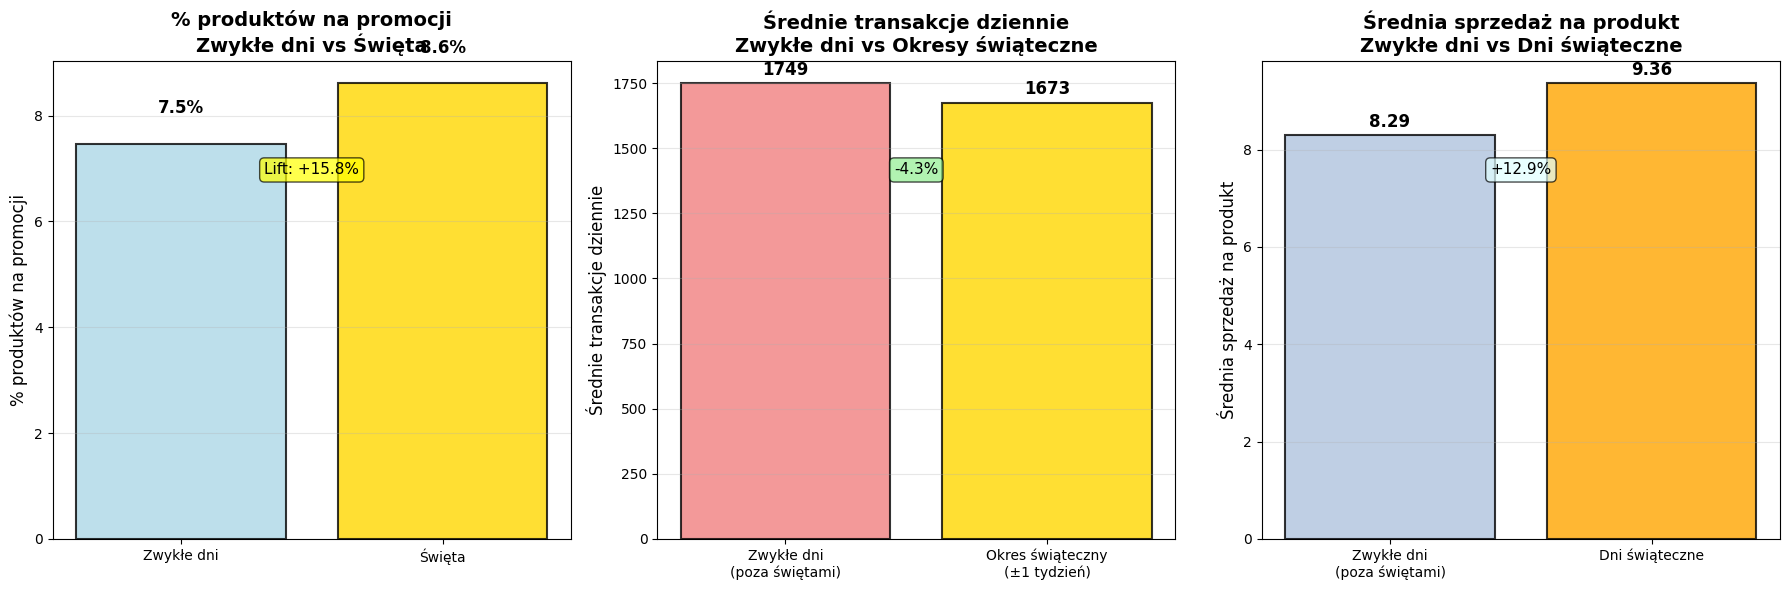

In [ ]:
# WIZUALIZACJE: PROMOCJE vs ŚWIĘTA i SPRZEDAŻ w OKRESACH ŚWIĄTECZNYCH
if 'clean_data' in locals() and len(clean_data) > 0:
        # Memory-safe visualization for large datasets
        if len(clean_data) > 500000:
            viz_data = clean_data.sample(n=500000, random_state=42)
        else:
            viz_data = clean_data.copy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # WYKRES 1: Podstawowe porównanie promocji
        promo_comparison = viz_data.groupby('is_holiday')['is_promotion'].mean() * 100
        categories = ['Zwykłe dni', 'Święta']
        
        val_false = promo_comparison.get(False, 0) if False in promo_comparison.index else 0
        val_true = promo_comparison.get(True, 0) if True in promo_comparison.index else 0
        values = [val_false, val_true]
        colors = ['lightblue', 'gold']
        
        bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax1.set_title('% produktów na promocji\nZwykłe dni vs Święta', fontsize=14, fontweight='bold')
        ax1.set_ylabel('% produktów na promocji', fontsize=12)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar, value in zip(bars1, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        if 'promo_lift_holidays' in locals():
            ax1.text(0.5, max(values) * 0.8, f'Lift: {promo_lift_holidays:+.1f}%', 
                    ha='center', transform=ax1.transData, fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        # WYKRES 2: ŚREDNIE TRANSAKCJE - Okresy świąteczne (±tydzień) vs zwykłe dni
        if 'transactions' in locals() and len(transactions) > 0 and 'national_holidays' in locals():
            # Analiza transakcji na poziomie dni
            trans_data = transactions.copy()
            trans_data['date'] = pd.to_datetime(trans_data['date'])
            
            # Definicja okresów świątecznych
            holiday_trans = []
            regular_trans = []
            
            all_holiday_dates = set()
            for _, holiday in national_holidays.head(20).iterrows():
                holiday_date = holiday['date']
                
                # Okres świąteczny: święto +/- 7 dni
                for offset in range(-7, 8):
                    check_date = holiday_date + pd.Timedelta(days=offset)
                    all_holiday_dates.add(check_date)
                    day_trans = trans_data[trans_data['date'] == check_date]
                    if len(day_trans) > 0:
                        avg_daily_trans = day_trans['transactions'].mean()
                        holiday_trans.append(avg_daily_trans)
            
            # Okres regularny
            regular_days = trans_data[~trans_data['date'].isin(all_holiday_dates)]
            if len(regular_days) > 100:
                regular_sample = regular_days.sample(n=min(len(holiday_trans)*2, 500), random_state=42)
                regular_trans = regular_sample['transactions'].tolist()
            
            if holiday_trans and regular_trans:
                holiday_avg_trans = np.mean(holiday_trans)
                regular_avg_trans = np.mean(regular_trans)
                
                period_categories = ['Zwykłe dni\n(poza świętami)', 'Okres świąteczny\n(±1 tydzień)']
                period_values = [regular_avg_trans, holiday_avg_trans]
                period_colors = ['lightcoral', 'gold']
                
                bars2 = ax2.bar(period_categories, period_values, color=period_colors, 
                               alpha=0.8, edgecolor='black', linewidth=1.5)
                ax2.set_title('Średnie transakcje dziennie\nZwykłe dni vs Okresy świąteczne', fontsize=14, fontweight='bold')
                ax2.set_ylabel('Średnie transakcje dziennie', fontsize=12)
                ax2.grid(axis='y', alpha=0.3)
                
                # Dodaj wartości na słupkach
                for bar, value in zip(bars2, period_values):
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(period_values)*0.01,
                            f'{value:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
                
                # Dodaj różnicę procentową
                percentage_diff = ((holiday_avg_trans - regular_avg_trans) / regular_avg_trans) * 100
                ax2.text(0.5, max(period_values) * 0.8, f'{percentage_diff:+.1f}%', 
                        ha='center', transform=ax2.transData, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
                
            else:
                ax2.text(0.5, 0.5, 'Za mało danych\no transakcjach', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title('Analiza transakcji niedostępna')
        else:
            ax2.text(0.5, 0.5, 'Brak danych\no transakcjach', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Analiza transakcji niedostępna')
        
        
        # WYKRES 3: CAŁKOWITA/ŚREDNIA SPRZEDAŻ - Okresy świąteczne vs zwykłe dni
        if 'clean_data' in locals() and len(clean_data) > 0:
            # Analiza sprzedaży bezpośrednio z clean_data
            holiday_sales = []
            regular_sales = []
            
            # Okresy świąteczne
            holiday_data = clean_data[clean_data['is_holiday'] == True]
            if len(holiday_data) > 0:
                holiday_sales = holiday_data['unit_sales'].tolist()
            
            # Okresy regularne  
            regular_data = clean_data[clean_data['is_holiday'] == False]
            if len(regular_data) > 0:
                # Sample dla wydajności
                if len(regular_data) > 10000:
                    regular_sample = regular_data.sample(n=10000, random_state=42)
                else:
                    regular_sample = regular_data
                regular_sales = regular_sample['unit_sales'].tolist()
            
            if holiday_sales and regular_sales:
                # Oblicz średnie i sumy
                holiday_avg_sales = np.mean(holiday_sales) 
                regular_avg_sales = np.mean(regular_sales)
                
                holiday_total_sales = np.sum(holiday_sales)
                regular_total_sales = np.sum(regular_sales)
                
                # Wybierz metrykę (można zmienić)
                metric = 'avg'  # 'avg' dla średniej, 'total' dla całkowitej
                
                if metric == 'total':
                    sales_values = [regular_total_sales, holiday_total_sales]
                    sales_name = 'Całkowita sprzedaż'
                    metric_name = 'całkowita'
                else:
                    sales_values = [regular_avg_sales, holiday_avg_sales]
                    sales_name = 'Średnia sprzedaż na produkt'
                    metric_name = 'średnia'
                
                periods_categories = ['Zwykłe dni\n(poza świętami)', 'Dni świąteczne']
                periods_colors = ['lightsteelblue', 'orange']
                
                bars = ax3.bar(periods_categories, sales_values, color=periods_colors, 
                              alpha=0.8, edgecolor='black', linewidth=1.5)
                ax3.set_title(f'{sales_name}\nZwykłe dni vs Dni świąteczne', fontsize=14, fontweight='bold')
                ax3.set_ylabel(f'{sales_name}', fontsize=12)
                ax3.grid(axis='y', alpha=0.3)
                
                # Dodaj wartości na słupkach
                for bar, value in zip(bars, sales_values):
                    if metric == 'total':
                        text_val = f'{value:.0f}'
                    else:
                        text_val = f'{value:.2f}'
                    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sales_values)*0.01,
                            text_val, ha='center', va='bottom', fontweight='bold', fontsize=12)
                
                # Dodaj różnicę procentową
                sales_percentage_diff = ((sales_values[1] - sales_values[0]) / sales_values[0]) * 100
                ax3.text(0.5, max(sales_values) * 0.8, f'{sales_percentage_diff:+.1f}%', 
                        ha='center', transform=ax3.transData, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcyan", alpha=0.7))
                
            else:
                ax3.text(0.5, 0.5, 'Za mało danych\no sprzedaży\n(brak rekordów)', 
                        ha='center', va='center', transform=ax3.transAxes, fontsize=12)
                ax3.set_title('Analiza sprzedaży: brak danych')
        else:
            ax3.text(0.5, 0.5, 'Brak danych\n(clean_data)', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Analiza sprzedaży niedostępna')
        
        plt.tight_layout()
        plt.show()
        